<a href="https://colab.research.google.com/github/SerhiiKutkovskyiDA/E-commerce-Sales-Analytics/blob/main/E_commerce_Sales_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview: Online Store Sales Analysis
**[Tableau Dashboard](https://public.tableau.com/app/discover)**   
  
This project presents a comprehensive analysis of an online store's sales data. The primary objective is to extract valuable insights from the raw data to understand sales performance, customer behavior, and the effectiveness of marketing channels.

The analysis is structured into several key stages:
1.  **Data Extraction:** Connecting to a Google BigQuery database and fetching a consolidated dataset using a custom SQL query.
2.  **Exploratory Data Analysis (EDA):** Performing an initial investigation of the dataset to understand its structure, identify data types, and check for missing values.
3.  **In-depth Analysis:** Answering specific business questions related to sales geography, product performance, customer demographics, and traffic sources.
4.  **Statistical Analysis:** Applying statistical methods to uncover correlations between key metrics and identify significant differences between customer groups.
5.  **Dashboarding:** Creating an interactive dashboard in Tableau to visualize the main findings and provide an at-a-glance overview of the business performance.

The tools used in this project are **SQL** (for data querying), **Python** (for data analysis and statistics), and **Tableau** (for data visualization).

---

### 1. Data Extraction from Google BigQuery

This section covers the initial setup and data retrieval process. The process involves installing the necessary Python libraries for interacting with Google Cloud, authenticating the environment to grant access to BigQuery, and then executing a SQL query to fetch and consolidate the required data into a pandas DataFrame.

The SQL query is designed to join multiple tables to create a comprehensive dataset for analysis. It uses `LEFT JOIN`s to ensure that all sessions are retained, even those without associated orders or registered user information, which is crucial for a complete view of user activity.

In [11]:
# Install necessary libraries for Google Cloud and data manipulation
# !pip install google-cloud-bigquery pandas pyarrow db-dtypes

import pandas as pd
from google.colab import auth
from google.cloud import bigquery

# --- Authenticate and initialize the client ---
# This command will trigger a pop-up for authentication in a Google Colab environment.
auth.authenticate_user()
print('Authentication complete.')

# Set the project ID
project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

# --- Define and execute the SQL query ---
# This query joins session, parameter, account, order, and product data.
sql_query = """
SELECT
    s.date,
    s.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.medium,
    sp.channel,
    acs.account_id,
    acc.is_verified,
    acc.is_unsubscribed,
    p.category,
    p.name,
    p.price,
    p.short_description
FROM
    `DA.session` s
JOIN
    `DA.session_params` sp ON s.ga_session_id = sp.ga_session_id
LEFT JOIN
    `DA.account_session` acs ON s.ga_session_id = acs.ga_session_id
LEFT JOIN
    `DA.account` acc ON acs.account_id = acc.id
LEFT JOIN
    `DA.order` o ON s.ga_session_id = o.ga_session_id
LEFT JOIN
    `DA.product` p ON o.item_id = p.item_id
"""

# Execute the query and load the result into a pandas DataFrame
df = client.query(sql_query).to_dataframe()

# Display the first few rows and the shape of the DataFrame to verify the result
print("DataFrame created successfully.")
print(f"Shape of the DataFrame: {df.shape}")
df.head()

Authentication complete.
DataFrame created successfully.
Shape of the DataFrame: (349545, 18)


,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None



---
### 2. Exploratory Data Analysis (EDA)

The first step in any data analysis project is to perform an initial exploratory analysis. This section provides a high-level overview of the dataset. The goals are to understand the data's structure, identify the types of data in each column, check for completeness, and get a general sense of the information available.

This includes:
* Displaying general information about the DataFrame, including column data types and non-null counts.
* Identifying and listing numeric, categorical, and datetime columns.
* Calculating the number of unique sessions.
* Determining the time period covered by the data.
* Quantifying and analyzing missing values to understand their potential impact and cause.

In [12]:
import pandas as pd

# --- Ensure the 'date' column is in datetime format ---
# This is crucial for correct time-series analysis.
df['date'] = pd.to_datetime(df['date'])

# --- Display general DataFrame information ---
print("--- DataFrame Info ---")
df.info()
print("\n" + "="*50 + "\n")

# --- Describe the dataset structure ---
print("--- Dataset Description ---")
total_cols = df.shape[1]
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'boolean']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

print(f"Total number of columns: {total_cols}")
print(f"Number of numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Number of categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Number of datetime columns ({len(datetime_cols)}): {datetime_cols}\n")

# --- Analyze sessions and time period ---
unique_sessions = df['ga_session_id'].nunique()
start_date = df['date'].min().strftime('%Y-%m-%d')
end_date = df['date'].max().strftime('%Y-%m-%d')

print(f"Number of unique sessions: {unique_sessions}")
print(f"Time period under review: from {start_date} to {end_date}\n")

# --- Analyze missing values ---
print("--- Missing Values Analysis ---")
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_values_percent
})

# Display columns with a significant number of missing values
print(missing_df[missing_df['Missing Count'] > 0])



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               349545 non-null  datetime64[ns]
 1   ga_session_id      349545 non-null  Int64         
 2   continent          349545 non-null  object        
 3   country            349545 non-null  object        
 4   device             349545 non-null  object        
 5   browser            349545 non-null  object        
 6   mobile_model_name  349545 non-null  object        
 7   operating_system   349545 non-null  object        
 8   language           235279 non-null  object        
 9   medium             349545 non-null  object        
 10  channel            349545 non-null  object        
 11  account_id         27945 non-null   Int64         
 12  is_verified        27945 non-null   Int64         
 13  is_unsubscribed    27

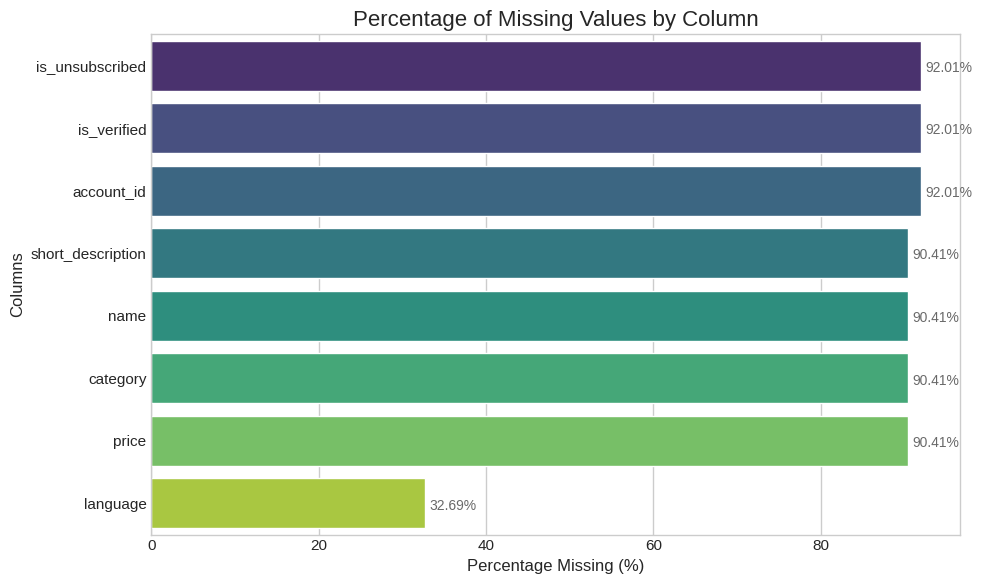

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare data for plotting ---
# Filter the missing_df to include only columns with missing values
missing_to_plot = missing_df[missing_df['Missing Count'] > 0]

# --- Create the visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar plot using the updated syntax
sns.barplot(
    x=missing_to_plot['Missing Percentage'],
    y=missing_to_plot.index,
    ax=ax,
    hue=missing_to_plot.index,
    palette='viridis',
    legend=False
)

# --- Customize the plot ---
ax.set_title('Percentage of Missing Values by Column', fontsize=16)
ax.set_xlabel('Percentage Missing (%)', fontsize=12)
ax.set_ylabel('Columns', fontsize=12)

# Add percentage labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.5, i.get_y() + 0.5,
            f"{i.get_width():.2f}%",
            fontsize=10,
            color='dimgray')

# Ensure layout is tight and save the figure
plt.tight_layout()
plt.savefig('missing_values_visualization.png')

# Display the plot
plt.show()

---
### 3. Geographical Sales Analysis

This section begins the in-depth analysis by focusing on the geographical distribution of sales. The goal is to identify the top-performing continents and countries based on two key metrics:
1.  **Total Sales Revenue:** The sum of the `price` for all items sold.
2.  **Total Number of Orders:** The total count of items sold.

Understanding these key markets is fundamental for strategic decisions in marketing, logistics, and business development. The results are visualized in a 2x2 grid to provide a clear, comparative view of performance across different geographical scales.

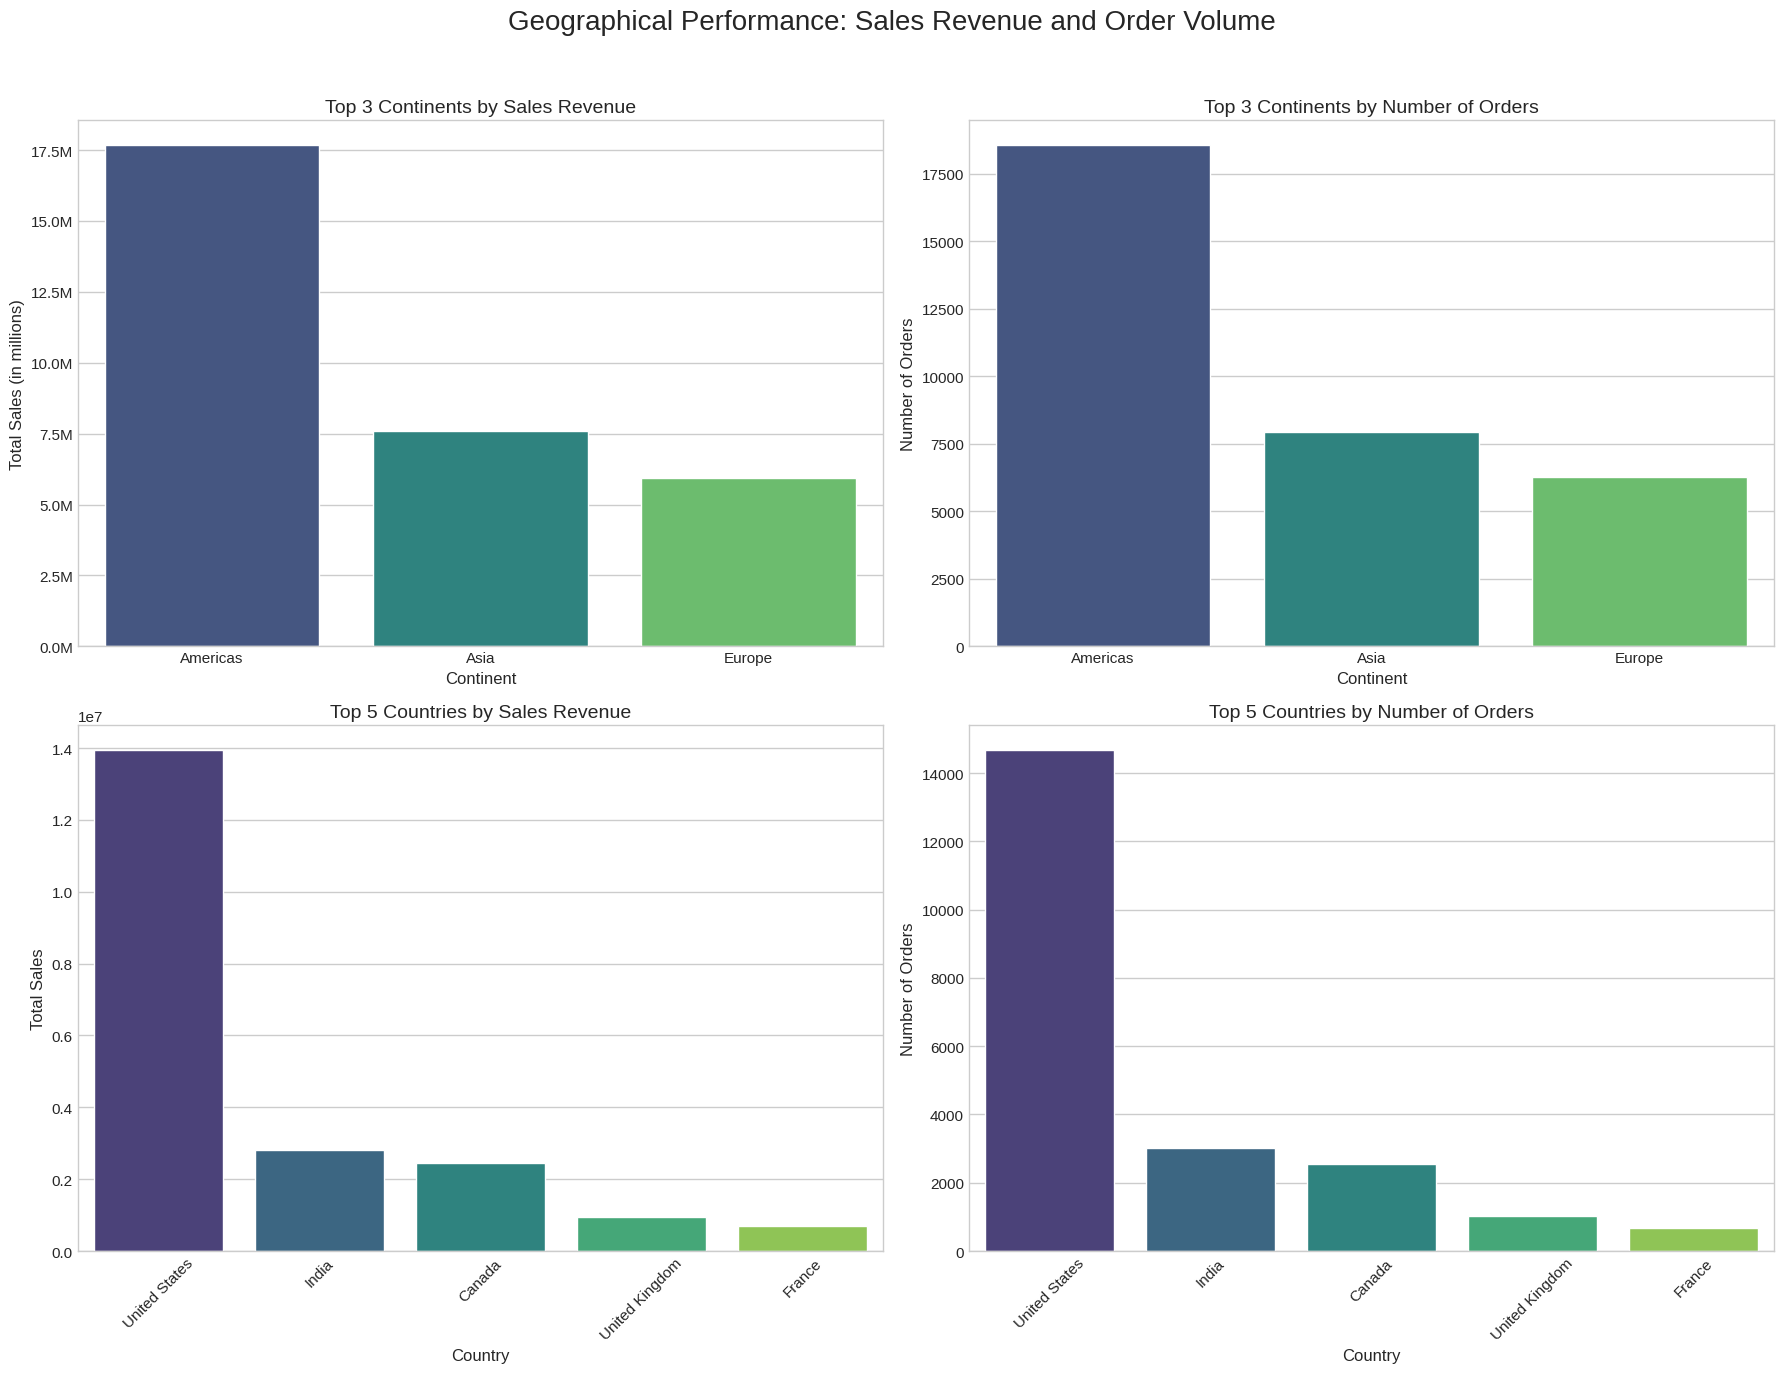

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- Data Preparation ---
# We analyze only the rows where a sale occurred, so we drop rows with no price information.
df_sales = df.dropna(subset=['price']).copy()
# Ensure price is a numeric type for calculations
df_sales['price'] = pd.to_numeric(df_sales['price'])


# --- Continent Analysis ---
# Group by continent and aggregate to get total sales and order count
continent_performance = df_sales.groupby('continent').agg(
    total_sales=('price', 'sum'),
    total_orders=('price', 'count')
).reset_index()

# Get top 3 continents for each metric
top_3_continents_sales = continent_performance.sort_values(by='total_sales', ascending=False).head(3)
top_3_continents_orders = continent_performance.sort_values(by='total_orders', ascending=False).head(3)


# --- Country Analysis ---
# Group by country and aggregate
country_performance = df_sales.groupby('country').agg(
    total_sales=('price', 'sum'),
    total_orders=('price', 'count')
).reset_index()

# Get top 5 countries for each metric
top_5_countries_sales = country_performance.sort_values(by='total_sales', ascending=False).head(5)
top_5_countries_orders = country_performance.sort_values(by='total_orders', ascending=False).head(5)


# --- Visualization ---
fig, ax = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Geographical Performance: Sales Revenue and Order Volume', fontsize=20)

# Plot 1: Top 3 Continents by Sales
sns.barplot(data=top_3_continents_sales, x='continent', y='total_sales', ax=ax[0, 0], hue='continent', palette='viridis', legend=False)
ax[0, 0].set_title('Top 3 Continents by Sales Revenue', fontsize=14)
ax[0, 0].set_xlabel('Continent', fontsize=12)
ax[0, 0].set_ylabel('Total Sales (in millions)', fontsize=12)
ax[0, 0].yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f}M')


# Plot 2: Top 3 Continents by Orders
sns.barplot(data=top_3_continents_orders, x='continent', y='total_orders', ax=ax[0, 1], hue='continent', palette='viridis', legend=False)
ax[0, 1].set_title('Top 3 Continents by Number of Orders', fontsize=14)
ax[0, 1].set_xlabel('Continent', fontsize=12)
ax[0, 1].set_ylabel('Number of Orders', fontsize=12)


# Plot 3: Top 5 Countries by Sales
sns.barplot(data=top_5_countries_sales, x='country', y='total_sales', ax=ax[1, 0], hue='country', palette='viridis', legend=False)
ax[1, 0].set_title('Top 5 Countries by Sales Revenue', fontsize=14)
ax[1, 0].set_xlabel('Country', fontsize=12)
ax[1, 0].set_ylabel('Total Sales', fontsize=12)
ax[1, 0].tick_params(axis='x', rotation=45)


# Plot 4: Top 5 Countries by Orders
sns.barplot(data=top_5_countries_orders, x='country', y='total_orders', ax=ax[1, 1], hue='country', palette='viridis', legend=False)
ax[1, 1].set_title('Top 5 Countries by Number of Orders', fontsize=14)
ax[1, 1].set_xlabel('Country', fontsize=12)
ax[1, 1].set_ylabel('Number of Orders', fontsize=12)
ax[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('geographical_performance.png')
plt.show()

---
### 4. Top 10 Product Categories by Sales Revenue

After analyzing the geographical distribution of sales, the next logical step is to identify which product categories are the most lucrative. This analysis involves aggregating sales data by product category to determine the total revenue generated by each.

The findings are essential for making informed decisions regarding inventory management, marketing campaign focus, and strategic product placement. A horizontal bar chart is used to clearly display the top 10 performing categories, ordered by their total sales revenue.

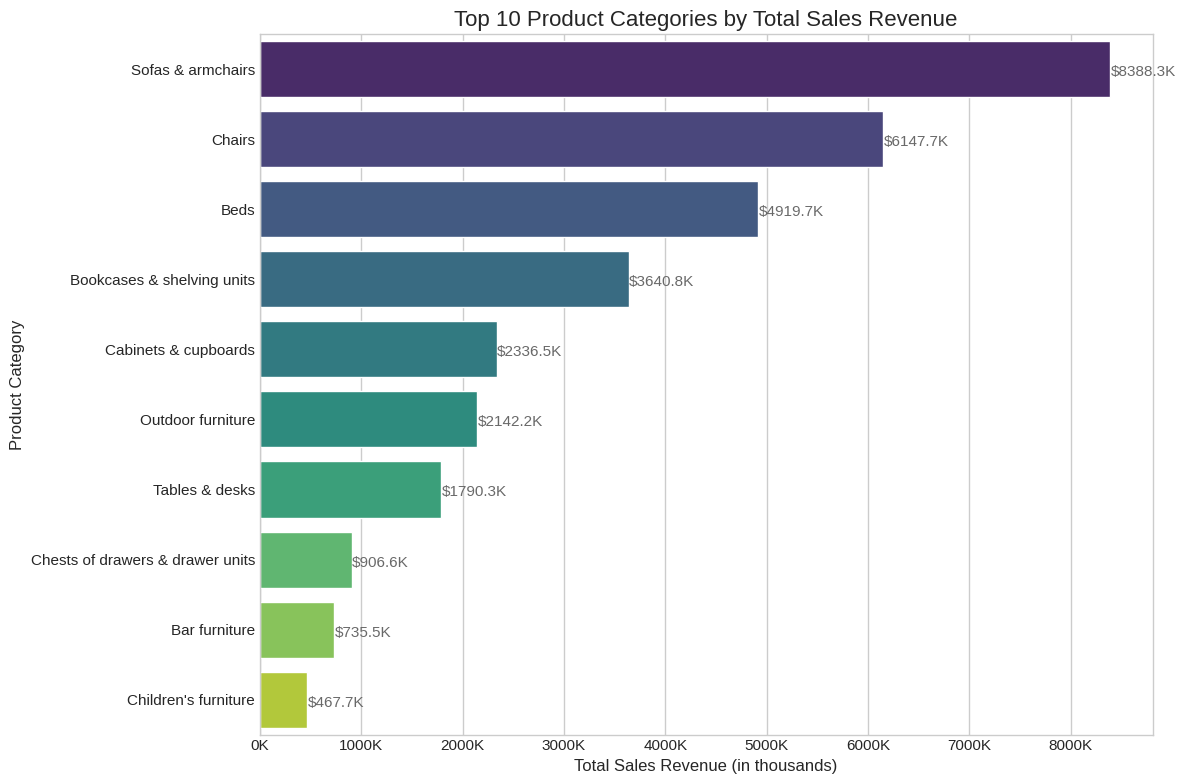

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Data Preparation ---
# We continue to use the df_sales DataFrame, which contains only sales data.

# --- Category Analysis ---
# Group by product category, sum the sales, sort, and get the top 10.
top_10_categories = df_sales.groupby('category')['price'].sum().sort_values(ascending=False).head(10)

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar plot
sns.barplot(
    x=top_10_categories.values,
    y=top_10_categories.index,
    ax=ax,
    hue=top_10_categories.index,
    palette='viridis',
    legend=False
)

# --- Customize the plot ---
ax.set_title('Top 10 Product Categories by Total Sales Revenue', fontsize=16)
ax.set_xlabel('Total Sales Revenue (in thousands)', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)

# Format x-axis labels to be more readable (e.g., 500K)
ax.xaxis.set_major_formatter(lambda x, pos: f'{x/1e3:.0f}K')

# Add value labels to the end of each bar
for i in ax.patches:
    ax.text(i.get_width() + 5000, i.get_y() + 0.5,
            f'${i.get_width()/1e3:.1f}K',
            fontsize=11,
            color='dimgray')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('top_10_categories_sales.png')
plt.show()

---
### 5. Comparative Analysis: Global vs. Top Country Category Sales

To better understand market-specific preferences, this analysis directly compares the top-10 best-selling product categories globally against those in the top-selling country. Placing these two charts side-by-side offers an immediate, clear view of which consumer trends are universal and which are unique to the primary market.

This direct comparison is a powerful tool for developing nuanced strategies, allowing for the alignment of global marketing efforts with targeted, regional promotions.

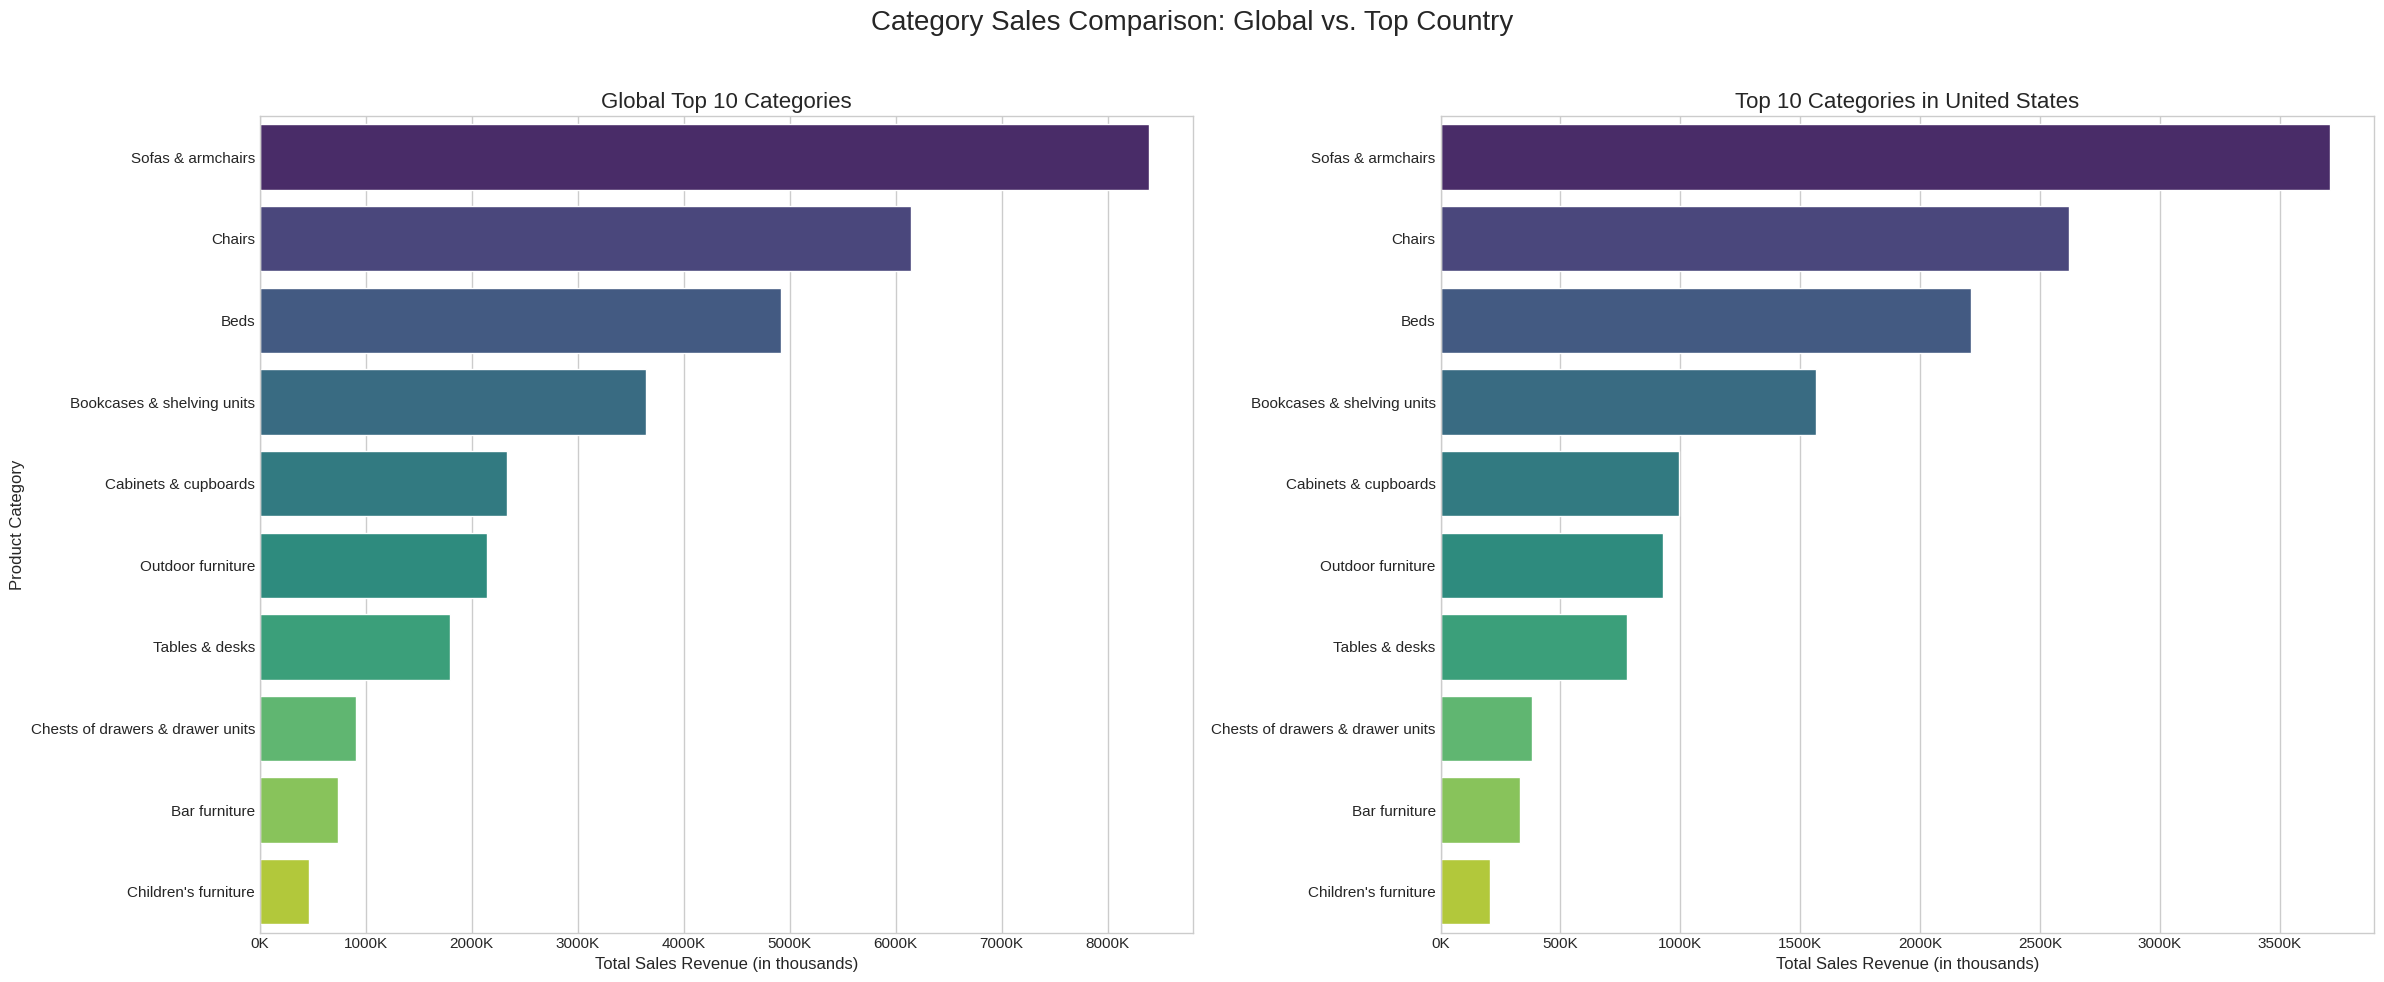

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We use the df_sales DataFrame which is already filtered for sales.

# 1. Calculate Global Top 10 Categories
top_10_categories_global = df_sales.groupby('category')['price'].sum().sort_values(ascending=False).head(10)

# 2. Identify Top Country and Calculate its Top 10 Categories
top_country_name = top_5_countries_sales['country'].iloc[0]
df_top_country = df_sales[df_sales['country'] == top_country_name].copy()
top_10_categories_country = df_top_country.groupby('category')['price'].sum().sort_values(ascending=False).head(10)

# --- Visualization (1x2 Matrix) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Category Sales Comparison: Global vs. Top Country', fontsize=20)

# --- Plot 1: Global Top 10 Categories (Left) ---
sns.barplot(
    x=top_10_categories_global.values,
    y=top_10_categories_global.index,
    ax=ax[0],
    hue=top_10_categories_global.index,
    palette='viridis',
    legend=False
)
ax[0].set_title('Global Top 10 Categories', fontsize=16)
ax[0].set_xlabel('Total Sales Revenue (in thousands)', fontsize=12)
ax[0].set_ylabel('Product Category', fontsize=12)
ax[0].xaxis.set_major_formatter(lambda x, pos: f'{x/1e3:.0f}K')

# --- Plot 2: Top Country's Top 10 Categories (Right) ---
sns.barplot(
    x=top_10_categories_country.values,
    y=top_10_categories_country.index,
    ax=ax[1],
    hue=top_10_categories_country.index,
    palette='viridis',
    legend=False
)
ax[1].set_title(f'Top 10 Categories in {top_country_name}', fontsize=16)
ax[1].set_xlabel('Total Sales Revenue (in thousands)', fontsize=12)
ax[1].set_ylabel('')

ax[1].xaxis.set_major_formatter(lambda x, pos: f'{x/1e3:.0f}K')


# --- Final Adjustments ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('top_categories_comparison.png')
plt.show()


### Interpretation of the Comparison

By viewing the charts side-by-side, you can now directly compare the rankings and sales volumes.

* **Consistent Winners:** Identify which categories appear high on **both** lists. These are your universally strong products.
* **Local Favorites:** Look for categories that rank significantly higher in the top country's list than on the global list (or do not appear on the global list at all). This indicates a strong local preference and a potential area for targeted marketing in that region.
* **Global Hits, Local Misses:** Conversely, a category might be a global top-performer but rank lower (or not appear) in the top country. This could signal market saturation, strong local competition, or a lack of cultural relevance, warranting further investigation.

---
### 6. Sales Analysis by Device

Understanding the technology customers use to make purchases is crucial for optimizing the user experience and marketing spend. This analysis breaks down the total sales revenue by:
1.  **Device Type:** The general category of the device (e.g., Desktop, Mobile, Tablet).
2.  **Top Mobile Device Models:** The specific mobile phone models that generate the most sales.

The results are presented as a percentage of total sales to clearly show the contribution of each segment. This insight is key to making data-driven decisions on web design (e.g., mobile-first vs. desktop-first) and targeted advertising.

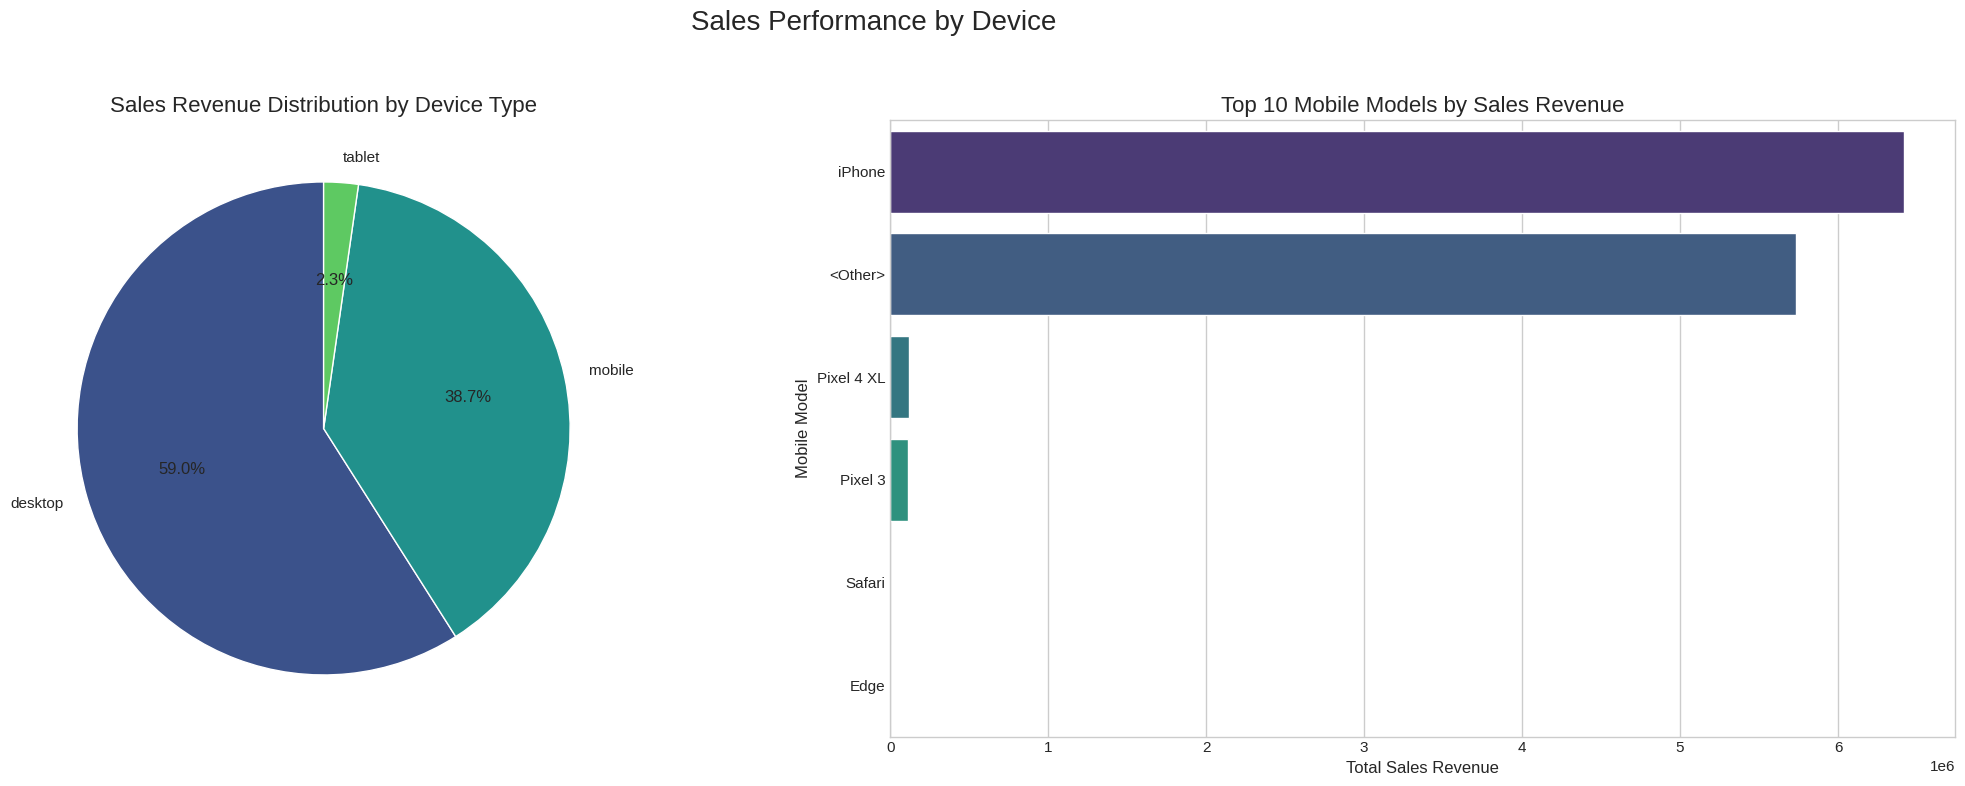

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We continue using the df_sales DataFrame, which contains only sales data.
total_sales_revenue = df_sales['price'].sum()

# --- Analysis by Device Type ---
device_sales = df_sales.groupby('device')['price'].sum().sort_values(ascending=False)
device_sales_percent = (device_sales / total_sales_revenue) * 100

# --- Analysis by Top 10 Mobile Models ---
# First, filter for mobile devices only, excluding placeholder names like '(not set)'.
df_mobile = df_sales[
    (df_sales['device'] == 'mobile') &
    (df_sales['mobile_model_name'] != '(not set)')
].copy()

# Group by model name and calculate sales for top 10 models
top_10_models = df_mobile.groupby('mobile_model_name')['price'].sum().sort_values(ascending=False).head(10)


# --- Visualization (1x2 Matrix) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Sales Performance by Device', fontsize=20)


# --- Plot 1: Sales Distribution by Device Type (Pie Chart) ---
ax[0].pie(
    device_sales_percent,
    labels=device_sales_percent.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('viridis', len(device_sales_percent))
)
ax[0].set_title('Sales Revenue Distribution by Device Type', fontsize=16)
ax[0].set_ylabel('')


# --- Plot 2: Top 10 Mobile Models by Sales (Bar Chart) ---
sns.barplot(
    x=top_10_models.values,
    y=top_10_models.index,
    ax=ax[1],
    hue=top_10_models.index,
    palette='viridis',
    legend=False
)
ax[1].set_title('Top 10 Mobile Models by Sales Revenue', fontsize=16)
ax[1].set_xlabel('Total Sales Revenue', fontsize=12)
ax[1].set_ylabel('Mobile Model', fontsize=12)


# --- Final Adjustments ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('device_sales_analysis.png')
plt.show()

---
### 7. Sales Analysis by Traffic Source

This analysis focuses on the effectiveness of different marketing efforts by attributing sales revenue to its original traffic source. Understanding which channels drive the most revenue is fundamental for strategic marketing budget allocation and campaign optimization.

We will break this down into two views:
1.  **By Traffic Channel:** A high-level overview of the broader categories (e.g., Organic Search, Direct, Referral).
2.  **By Traffic Medium:** A more granular look at the specific sources (e.g., organic, cpc, (none)).

A pie chart is used for the channel distribution to show parts of a whole, while a bar chart provides a clearer view of the more numerous medium categories.

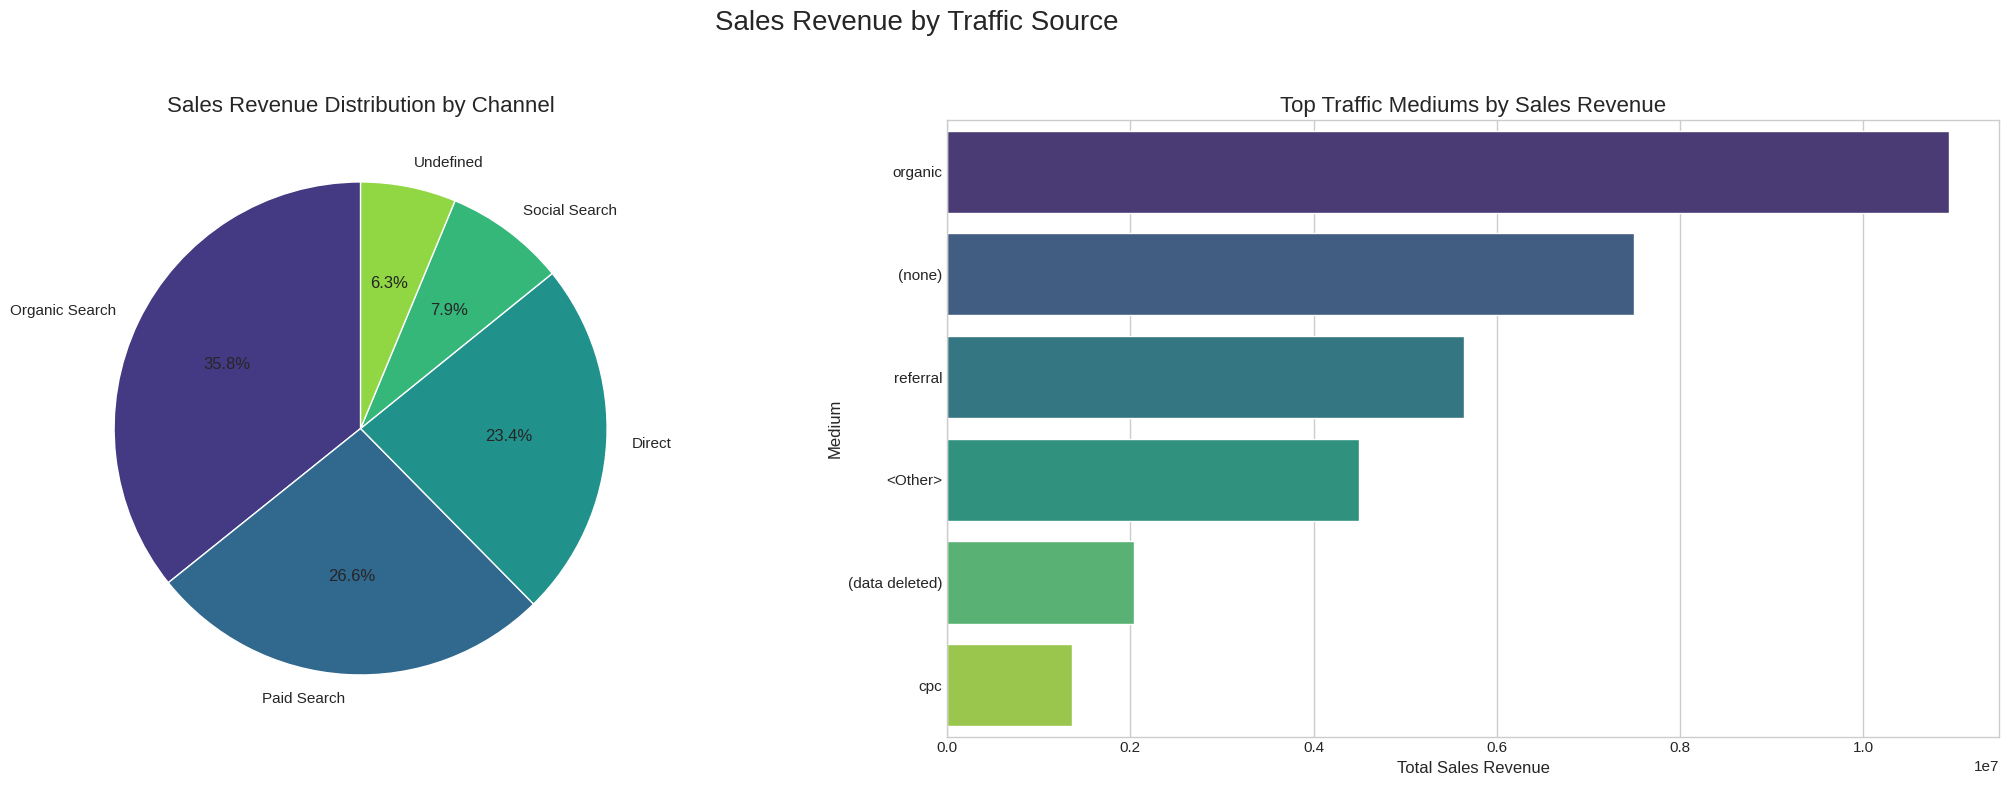

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We continue using the df_sales DataFrame and total_sales_revenue.

# --- Analysis by Channel ---
channel_sales = df_sales.groupby('channel')['price'].sum().sort_values(ascending=False)

# --- Analysis by Medium ---
medium_sales = df_sales.groupby('medium')['price'].sum().sort_values(ascending=False)


# --- Visualization (1x2 Matrix) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Sales Revenue by Traffic Source', fontsize=20)


# --- Plot 1: Sales Revenue by Traffic Channel (Pie Chart) ---
ax[0].pie(
    channel_sales,
    labels=channel_sales.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('viridis', len(channel_sales))
)
ax[0].set_title('Sales Revenue Distribution by Channel', fontsize=16)
ax[0].set_ylabel('')


# --- Plot 2: Sales Revenue by Traffic Medium (Bar Chart) ---
sns.barplot(
    x=medium_sales.values,
    y=medium_sales.index,
    ax=ax[1],
    hue=medium_sales.index,
    palette='viridis',
    legend=False
)
ax[1].set_title('Top Traffic Mediums by Sales Revenue', fontsize=16)
ax[1].set_xlabel('Total Sales Revenue', fontsize=12)
ax[1].set_ylabel('Medium', fontsize=12)


# --- Final Adjustments ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('traffic_source_sales_analysis.png')
plt.show()

---
### 8. Analysis of Registered Users: Email Verification Rate

This analysis shifts focus from sales to the user base itself. The first question we address is the email verification rate among registered users. A registered user is identified by having a non-null `account_id`.

This metric is a key indicator of user base health and engagement. A high verification rate leads to more effective email marketing campaigns, better data quality, and enhanced account security. The result is visualized using a donut chart to clearly display the proportion of verified versus unverified users.

Total unique registered users: 27945
Verified users: 20036
Verification Rate: 71.70%


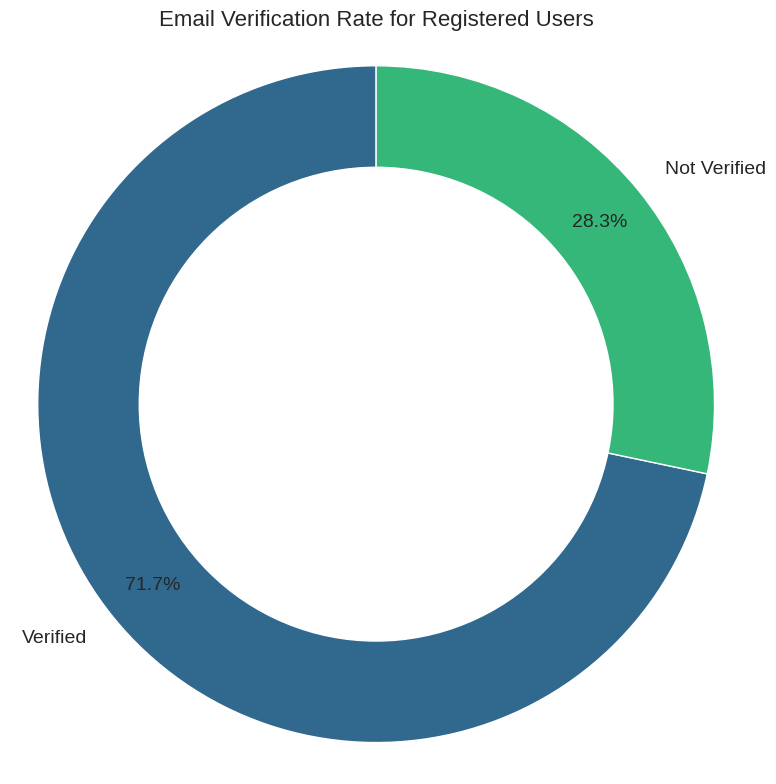

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We are interested in unique registered users.
# First, filter out sessions without a logged-in user.
df_users = df.dropna(subset=['account_id'])

# Then, get a unique entry for each user to avoid counting the same user multiple times.
df_unique_users = df_users.drop_duplicates(subset=['account_id']).copy()

# --- Calculation ---
# Total number of unique registered users
total_unique_users = len(df_unique_users)

# Number of users who have verified their email (assuming is_verified=1 for verified)
# The is_verified column is Int64, so we need to handle potential <NA> values if any, fillna(0) is safe.
verified_users_count = df_unique_users['is_verified'].fillna(0).astype(int).sum()

# Calculate the percentage
verification_percentage = (verified_users_count / total_unique_users) * 100

print(f"Total unique registered users: {total_unique_users}")
print(f"Verified users: {verified_users_count}")
print(f"Verification Rate: {verification_percentage:.2f}%")


# --- Visualization (Donut Chart) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))

# Data for the pie chart
labels = ['Verified', 'Not Verified']
sizes = [verification_percentage, 100 - verification_percentage]
colors = sns.color_palette('viridis', 2)

# Create the pie chart
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    textprops={'fontsize': 14}
)

# Create the "donut hole"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add a title and ensure the aspect ratio is equal
ax.set_title('Email Verification Rate for Registered Users', fontsize=16)
ax.axis('equal')


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('email_verification_rate.png')
plt.show()

---
### 9. Analysis of Registered Users: Newsletter Unsubscribe Rate

Following the verification analysis, we now examine the unsubscribe rate. This metric measures the percentage of registered users who have actively chosen to opt-out of email marketing communications.

A low unsubscribe rate is a positive sign, indicating that the content is relevant and valuable to the audience. Conversely, a high rate can signal issues with content quality, email frequency, or audience targeting. We will again use a donut chart for a clear visual representation.

Total unique registered users: 27945
Unsubscribed users: 4735
Unsubscribe Rate: 16.94%


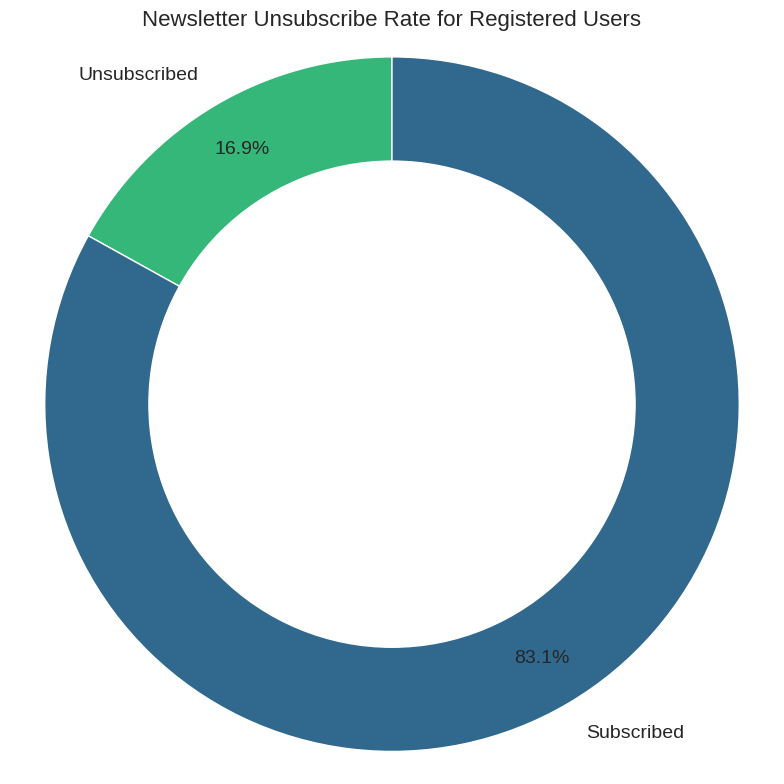

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We reuse the df_unique_users DataFrame which contains one row per unique registered user.

# --- Calculation ---
# Total number of unique registered users is already calculated as total_unique_users.

# Number of users who have unsubscribed (assuming is_unsubscribed=1 for unsubscribed).
# The is_unsubscribed column is Int64, fillna(0) is a safe way to handle potential <NA> values.
unsubscribed_users_count = df_unique_users['is_unsubscribed'].fillna(0).astype(int).sum()

# Calculate the percentage
unsubscribe_percentage = (unsubscribed_users_count / total_unique_users) * 100

print(f"Total unique registered users: {total_unique_users}")
print(f"Unsubscribed users: {unsubscribed_users_count}")
print(f"Unsubscribe Rate: {unsubscribe_percentage:.2f}%")


# --- Visualization (Donut Chart) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))

# Data for the pie chart
labels = ['Unsubscribed', 'Subscribed']
sizes = [unsubscribe_percentage, 100 - unsubscribe_percentage]
colors = sns.color_palette('viridis_r', 2)

# Create the pie chart
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    textprops={'fontsize': 14}
)

# Create the "donut hole"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add a title and ensure the aspect ratio is equal
ax.set_title('Newsletter Unsubscribe Rate for Registered Users', fontsize=16)
ax.axis('equal')


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('unsubscribe_rate.png')
plt.show()

---
### 10. Sales Behavior: Subscribed vs. Unsubscribed Users

This section compares the purchasing behavior of two key segments of registered users: those who remain subscribed to marketing emails and those who have opted out. Understanding the difference in their spending habits is crucial for evaluating the ROI of email marketing.

We will compare these two groups across three key metrics:
1.  **Total Sales Revenue:** The overall revenue generated by each group.
2.  **Total Number of Orders:** The volume of transactions from each group.
3.  **Average Revenue Per User (ARPU):** The average revenue generated per unique user in each group, which helps normalize for differences in group size.

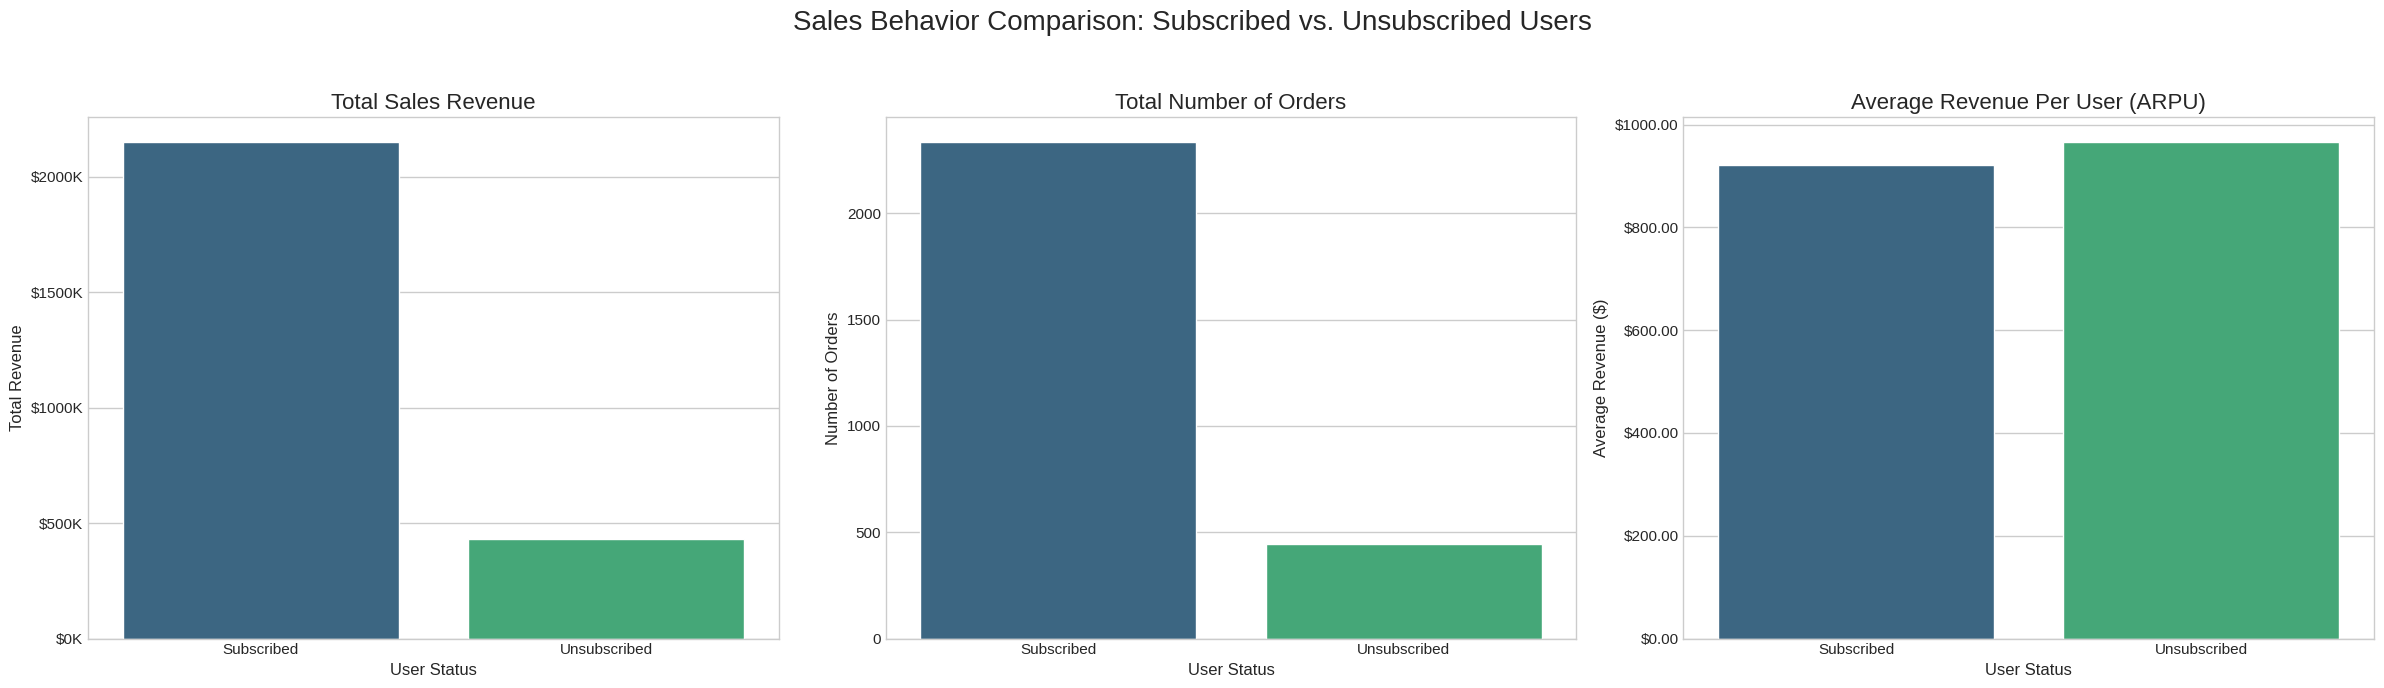

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Data Preparation ---
# We need to analyze sales made by registered users only.
# Filter the original DataFrame for sessions that have both a sale and a user account.
df_user_sales = df.dropna(subset=['price', 'account_id']).copy()

# Ensure data types are correct for calculation
df_user_sales['price'] = pd.to_numeric(df_user_sales['price'])
df_user_sales['is_unsubscribed'] = df_user_sales['is_unsubscribed'].fillna(0).astype(int)

# --- Metric Calculation ---
# Group by subscription status to calculate metrics
behavior_comparison = df_user_sales.groupby('is_unsubscribed').agg(
    total_sales=('price', 'sum'),
    total_orders=('price', 'count'),
    unique_users=('account_id', 'nunique')
).reset_index()

# Calculate Average Revenue Per User (ARPU)
behavior_comparison['arpu'] = behavior_comparison['total_sales'] / behavior_comparison['unique_users']

# Map the 'is_unsubscribed' flag to readable labels for plotting
behavior_comparison['status'] = behavior_comparison['is_unsubscribed'].map({0: 'Subscribed', 1: 'Unsubscribed'})


# --- Visualization (1x3 Matrix) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Sales Behavior Comparison: Subscribed vs. Unsubscribed Users', fontsize=20)


# Plot 1: Total Sales Revenue
sns.barplot(data=behavior_comparison, x='status', y='total_sales', ax=ax[0], hue='status', palette='viridis', legend=False)
ax[0].set_title('Total Sales Revenue', fontsize=16)
ax[0].set_xlabel('User Status', fontsize=12)
ax[0].set_ylabel('Total Revenue', fontsize=12)
ax[0].yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# Plot 2: Total Number of Orders
sns.barplot(data=behavior_comparison, x='status', y='total_orders', ax=ax[1], hue='status', palette='viridis', legend=False)
ax[1].set_title('Total Number of Orders', fontsize=16)
ax[1].set_xlabel('User Status', fontsize=12)
ax[1].set_ylabel('Number of Orders', fontsize=12)

# Plot 3: Average Revenue Per User (ARPU)
sns.barplot(data=behavior_comparison, x='status', y='arpu', ax=ax[2], hue='status', palette='viridis', legend=False)
ax[2].set_title('Average Revenue Per User (ARPU)', fontsize=16)
ax[2].set_xlabel('User Status', fontsize=12)
ax[2].set_ylabel('Average Revenue ($)', fontsize=12)
ax[2].yaxis.set_major_formatter(lambda x, pos: f'${x:.2f}')


# --- Final Adjustments ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('sales_behavior_comparison.png')
plt.show()

---
### 11. Top Countries by Number of Registered Users

To complete our user-centric analysis, we now identify the countries with the highest number of registered users. This provides a geographical map of our most engaged user base, which may differ from the map of top-selling countries.

This insight is valuable for strategic planning related to localization, country-specific marketing campaigns, and customer support resource allocation. A horizontal bar chart is used to display the top 10 countries, making it easy to see the distribution.

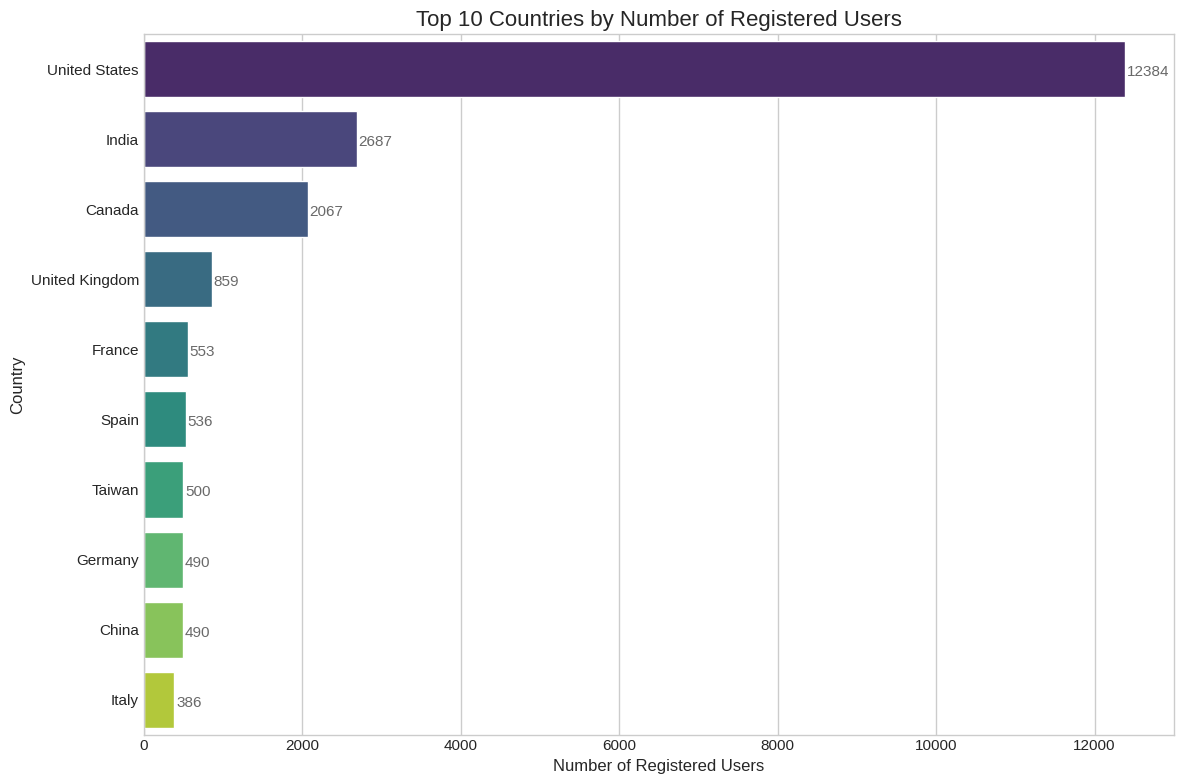

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We use the df_unique_users DataFrame, which contains one row per unique registered user.

# --- Calculation ---
# Group by country and count the number of unique users.
top_countries_by_users = df_unique_users['country'].value_counts().head(10)


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar plot
sns.barplot(
    x=top_countries_by_users.values,
    y=top_countries_by_users.index,
    ax=ax,
    hue=top_countries_by_users.index,
    palette='viridis',
    legend=False
)

# --- Customize the plot ---
ax.set_title('Top 10 Countries by Number of Registered Users', fontsize=16)
ax.set_xlabel('Number of Registered Users', fontsize=12)
ax.set_ylabel('Country', fontsize=12)

# Add data labels to each bar
for i in ax.patches:
    ax.text(i.get_width() + 20, i.get_y() + 0.5,
            f'{int(i.get_width())}',
            fontsize=11,
            color='dimgray')


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('top_countries_by_users.png')
plt.show()

---

# **Sales Dynamics Analysis**

This next major section of the project focuses on time-series analysis to understand how sales performance evolves over time. By analyzing temporal patterns, we can identify trends, seasonality, and the impact of specific events.

### 12. Overall Daily Sales Dynamics

The first step is to visualize the total sales revenue for each day across the entire dataset period. This provides a high-level overview of the business's daily performance. A line chart is the ideal visualization for this purpose as it clearly shows trends, peaks, and troughs. To better visualize the underlying trend and smooth out daily noise, a 7-day rolling average is also plotted.

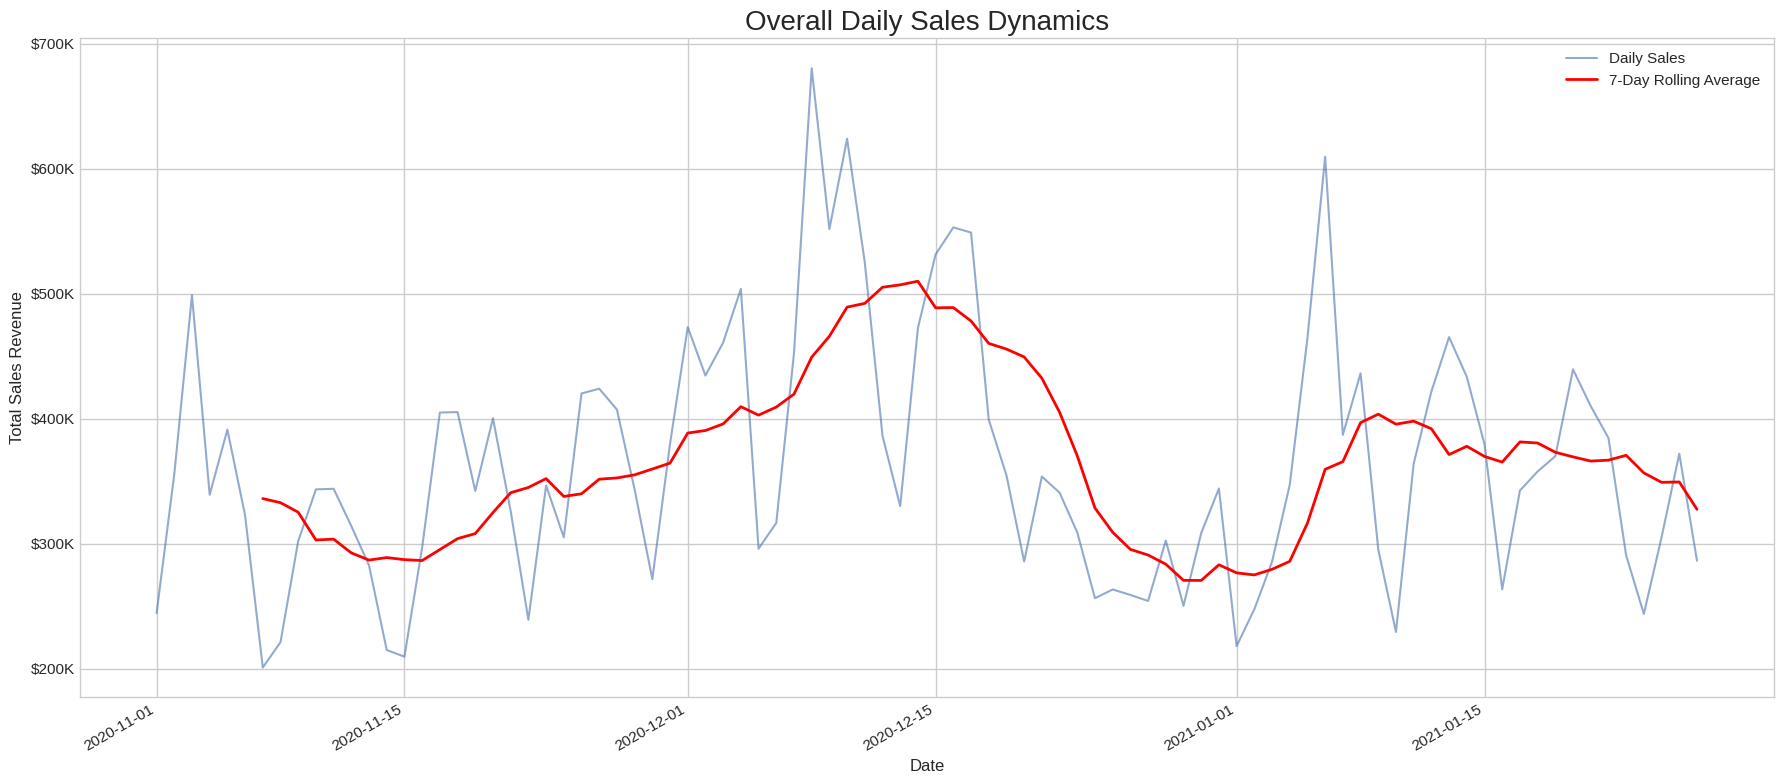

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# We use the df_sales DataFrame which is already filtered for sales and has a datetime 'date' column.

# --- Calculation ---
# Group by date and sum the sales to get total daily sales.
daily_sales = df_sales.groupby('date')['price'].sum()

# Calculate the 7-day rolling average to smooth the trend line.
rolling_avg_7d = daily_sales.rolling(window=7).mean()


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Plot the daily sales
sns.lineplot(
    x=daily_sales.index,
    y=daily_sales.values,
    ax=ax,
    label='Daily Sales',
    alpha=0.6
)

# Plot the 7-day rolling average
sns.lineplot(
    x=rolling_avg_7d.index,
    y=rolling_avg_7d.values,
    ax=ax,
    label='7-Day Rolling Average',
    color='red',
    linewidth=2
)

# --- Customize the plot ---
ax.set_title('Overall Daily Sales Dynamics', fontsize=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales Revenue', fontsize=12)
ax.legend()

# Format y-axis to be more readable
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# Ensure date ticks are displayed nicely
fig.autofmt_xdate()


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('daily_sales_dynamics.png')
plt.show()

---
### 13. Seasonality Analysis

Identifying seasonality is key to understanding the natural rhythm of the business. This analysis examines the daily sales data for two types of recurring patterns:

1.  **Holiday Peaks:** By observing the overall daily sales chart created in the previous step, we can identify significant spikes in revenue that likely correspond to major commercial events like Black Friday, Cyber Monday, and the pre-Christmas shopping period.
2.  **Weekly Cycles:** To uncover the typical weekly sales pattern, we will calculate the average sales revenue for each day of the week. This helps answer whether the business performs better on weekdays or weekends.

Understanding these patterns is essential for effective inventory planning, staff scheduling, and targeted marketing promotions.

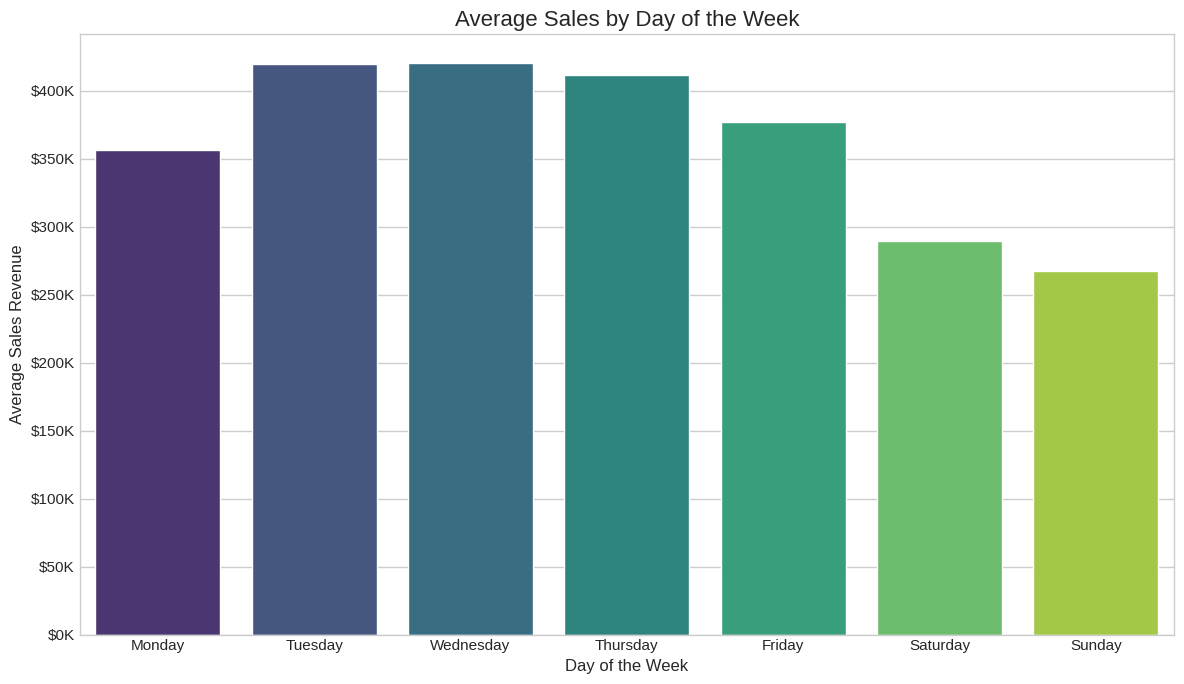

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Data Preparation ---
# We use the daily_sales Series from the previous step.
df_daily = pd.DataFrame({'sales': daily_sales})

# Add columns for the day of the week name and number (for sorting)
df_daily['day_of_week_name'] = df_daily.index.day_name()
df_daily['day_of_week_num'] = df_daily.index.dayofweek

# --- Calculation ---
# Group by day of the week and calculate the average sales.
weekly_avg_sales = df_daily.groupby(['day_of_week_num', 'day_of_week_name'])['sales'].mean().sort_index()

# Reset index to make day names a column for plotting
weekly_avg_sales = weekly_avg_sales.reset_index()


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create a bar plot for average daily sales
sns.barplot(
    data=weekly_avg_sales,
    x='day_of_week_name',
    y='sales',
    ax=ax,
    hue='day_of_week_name',
    palette='viridis',
    legend=False
)

# --- Customize the plot ---
ax.set_title('Average Sales by Day of the Week', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_ylabel('Average Sales Revenue', fontsize=12)
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('weekly_sales_seasonality.png')
plt.show()

---
### 14. Comparative Sales Dynamics by Continent

After examining the overall sales trend, it's important to understand how different major markets contribute to it. This analysis compares the daily sales dynamics for three key continents: the Americas, Asia, and Europe.

By plotting the sales trends for each continent on the same axes, we can easily compare their performance, identify regional responses to holidays or marketing campaigns, and spot diverging growth patterns that may require tailored strategies.

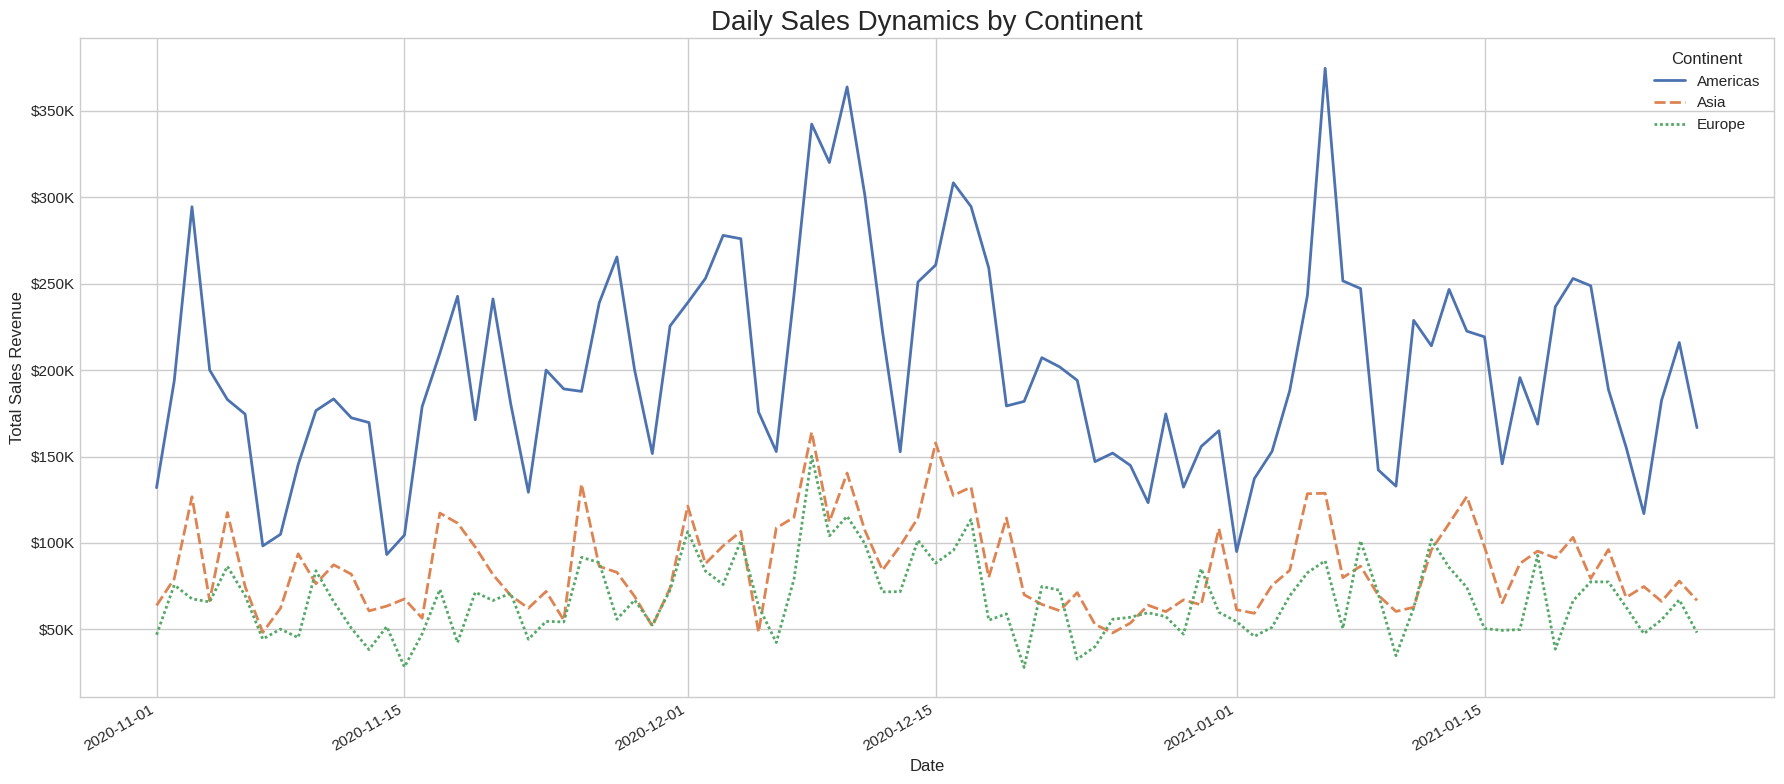

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Data Preparation ---
# We use the df_sales DataFrame which contains all sales data.

# Define the continents we want to focus on.
continents_to_analyze = ['Americas', 'Asia', 'Europe']
df_continents = df_sales[df_sales['continent'].isin(continents_to_analyze)].copy()

# --- Calculation ---
# Group by both date and continent, then sum the sales.
# .unstack() pivots the continent names into columns, which is ideal for plotting.
daily_sales_by_continent = df_continents.groupby(['date', 'continent'])['price'].sum().unstack()

# Fill any missing dates for a continuous line plot with 0
daily_sales_by_continent = daily_sales_by_continent.asfreq('D', fill_value=0)


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Seaborn can directly plot the DataFrame, creating a line for each column.
sns.lineplot(
    data=daily_sales_by_continent,
    ax=ax,
    linewidth=2
)

# --- Customize the plot ---
ax.set_title('Daily Sales Dynamics by Continent', fontsize=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales Revenue', fontsize=12)
ax.legend(title='Continent')

# Format y-axis to be more readable
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# Ensure date ticks are displayed nicely
fig.autofmt_xdate()


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('daily_sales_by_continent.png')
plt.show()

---
### 15. Comparative Sales Dynamics by Traffic Channel

Following the analysis by continent, we now segment the sales dynamics by traffic channel. This shows how different acquisition channels (e.g., Organic Search, Direct, Referral) contribute to revenue over time.

This visualization is useful for assessing the performance and stability of each channel. It helps identify which channels provide a consistent baseline of revenue and which are more volatile or event-driven. This insight is critical for optimizing marketing spend and balancing long-term and short-term acquisition strategies.

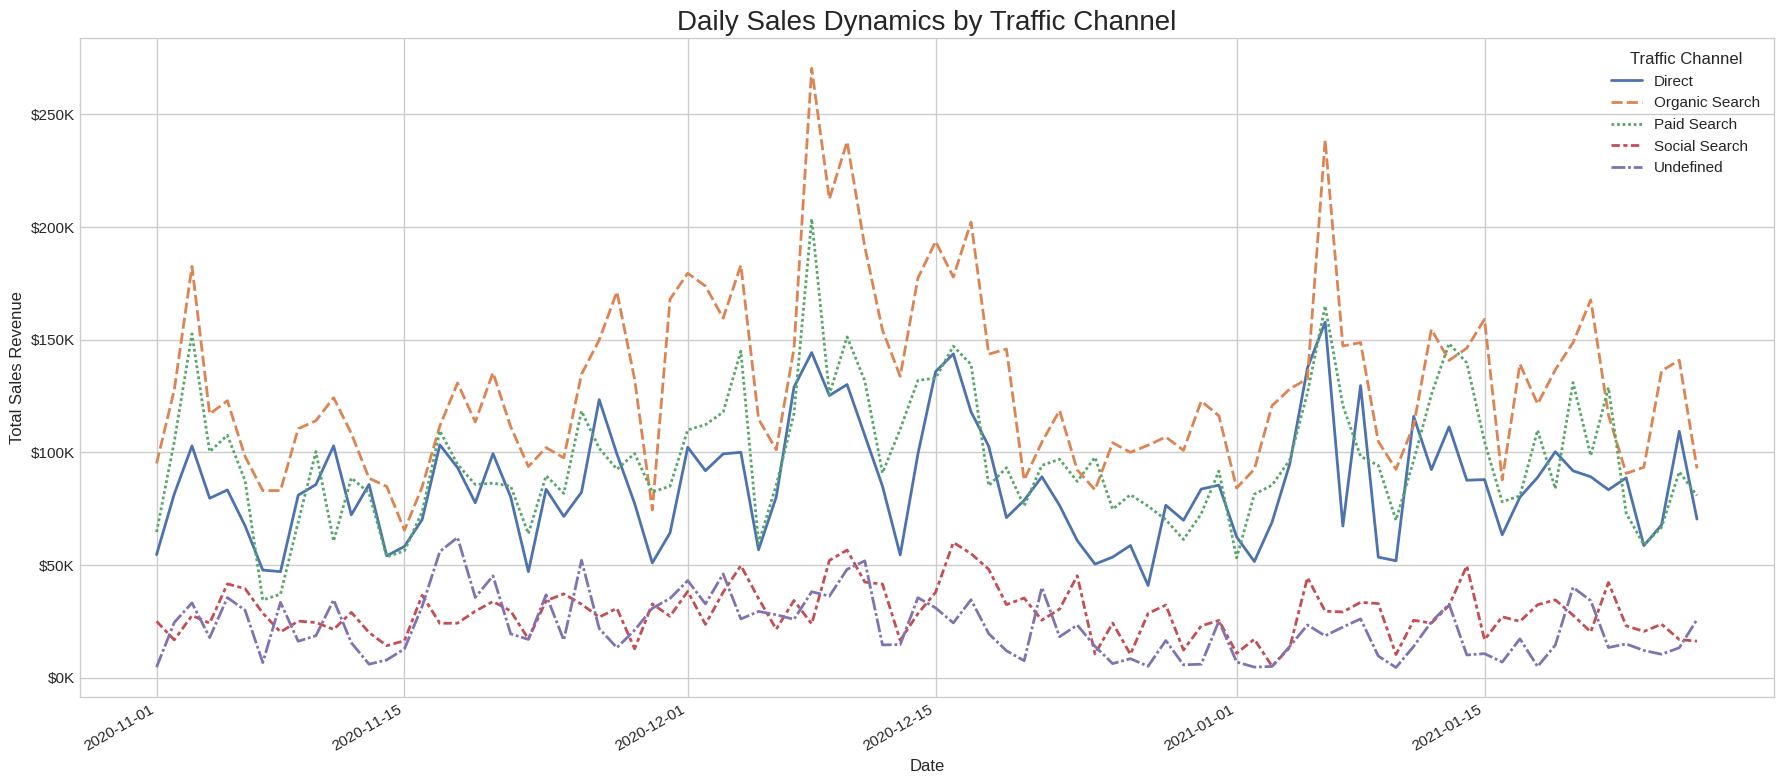

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Data Preparation ---
# We continue to use the df_sales DataFrame.

# --- Calculation ---
# Group by both date and channel, then sum the sales.
daily_sales_by_channel = df_sales.groupby(['date', 'channel'])['price'].sum().unstack()

# Fill any missing values with 0 to ensure continuous lines
daily_sales_by_channel = daily_sales_by_channel.fillna(0)


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Seaborn will plot a separate line for each column (channel) in the DataFrame.
sns.lineplot(
    data=daily_sales_by_channel,
    ax=ax,
    linewidth=2
)

# --- Customize the plot ---
ax.set_title('Daily Sales Dynamics by Traffic Channel', fontsize=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales Revenue', fontsize=12)
ax.legend(title='Traffic Channel')

# Format y-axis to be more readable
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# Ensure date ticks are displayed nicely
fig.autofmt_xdate()


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('daily_sales_by_channel.png')
plt.show()

---
### 16. Comparative Sales Dynamics by Device Type

To conclude the time-series analysis, we examine the sales dynamics segmented by device type. This comparison illustrates the purchasing trends on desktop, mobile, and tablet platforms over the entire period.

Understanding these trends is vital for allocating resources for web and application development. For example, a growing trend in mobile sales would reinforce the need for a mobile-first design philosophy. It also shows how device preferences might shift during different periods (e.g., more mobile shopping during holidays).

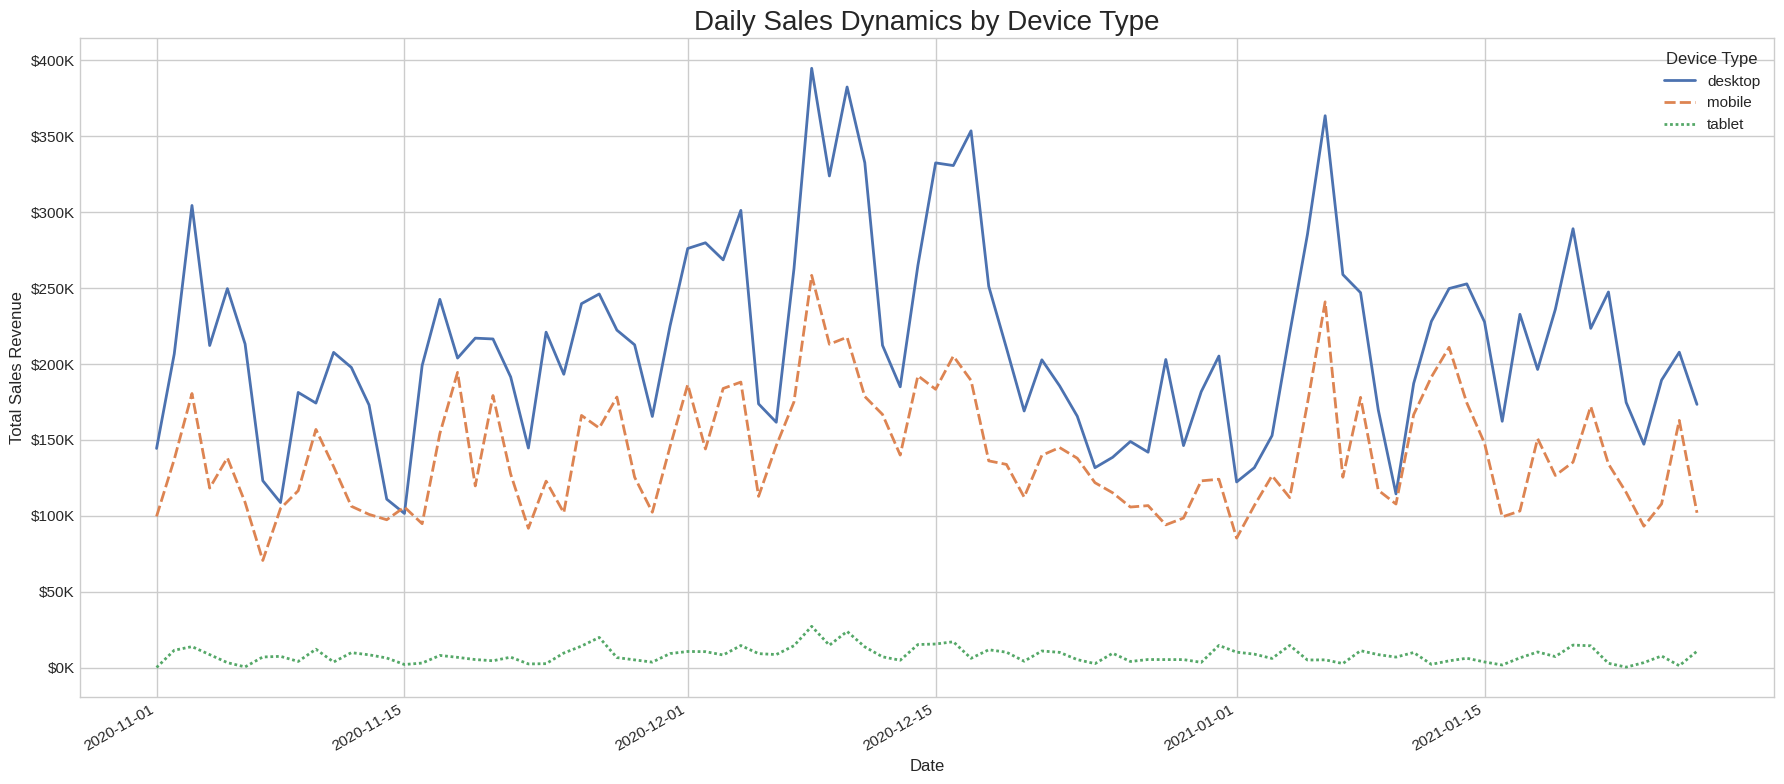

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Data Preparation ---
# We continue to use the df_sales DataFrame.

# --- Calculation ---
# Group by both date and device, then sum the sales.
daily_sales_by_device = df_sales.groupby(['date', 'device'])['price'].sum().unstack()

# Fill any missing values with 0 to ensure continuous lines
daily_sales_by_device = daily_sales_by_device.fillna(0)


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Seaborn will plot a separate line for each column (device) in the DataFrame.
sns.lineplot(
    data=daily_sales_by_device,
    ax=ax,
    linewidth=2
)

# --- Customize the plot ---
ax.set_title('Daily Sales Dynamics by Device Type', fontsize=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales Revenue', fontsize=12)
ax.legend(title='Device Type')

# Format y-axis to be more readable
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# Ensure date ticks are displayed nicely
fig.autofmt_xdate()


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('daily_sales_by_device.png')
plt.show()

### Conclusions from Sales Dynamics Analysis

After creating these visualizations, you can draw several conclusions. For example:
* The overall trend might show significant growth during the holiday season.
* Weekly patterns might indicate that customers prefer to shop on certain days.
* The comparison by continent could reveal that the holiday sales peak is much more pronounced in the Americas than in Asia.
* The traffic channel analysis might show that 'Direct' traffic is a consistent revenue source, while 'Referral' traffic peaks during specific campaigns.
* The device dynamics could show a clear dominance of one platform, like Desktop, for making purchases.

---

## Pivot Tables and Cross-Tabulations

In this section, we move from time-series analysis to creating pivot tables. Pivot tables are a powerful tool for summarizing data and viewing it from different perspectives by cross-referencing multiple categories.

---

### 17. Session Count by Traffic Channel and Device Type

Our first pivot table will show the number of unique sessions for each combination of traffic channel and device type. The results will be presented as both a raw table and a heatmap.

A heatmap is an excellent way to visualize a pivot table, as it uses color intensity to represent the magnitude of the values in the cells. This makes it easy to spot the "hotspots"—the combinations of channel and device that drive the most user sessions. This insight is crucial for optimizing marketing campaigns across different platforms.

--- Pivot Table: Session Count by Channel and Device ---
device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


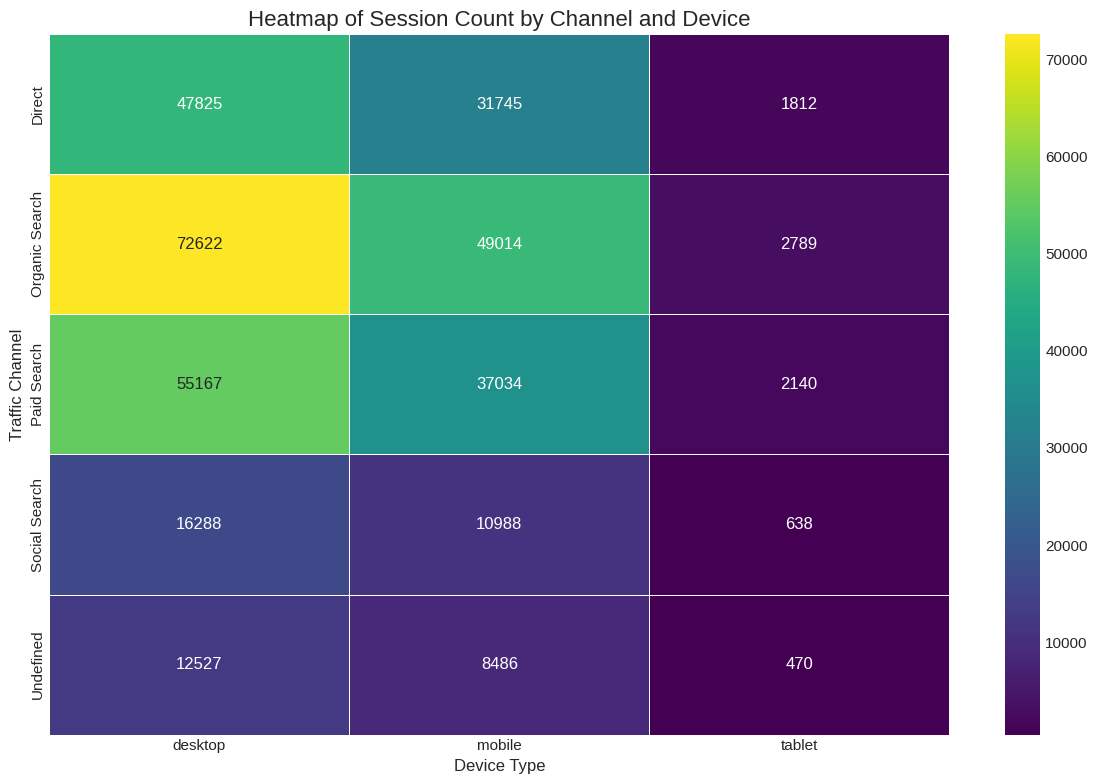

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
df_sessions = df.dropna(subset=['channel', 'device']).copy()

# --- Pivot Table Creation ---
session_pivot_table = pd.pivot_table(
    df_sessions,
    index='channel',
    columns='device',
    values='ga_session_id',
    aggfunc='nunique',
    fill_value=0
)

print("--- Pivot Table: Session Count by Channel and Device ---")
print(session_pivot_table)


# --- Visualization (Heatmap) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# A heatmap is used to visualize the pivot table's data.
sns.heatmap(
    session_pivot_table,
    annot=True,
    fmt='d',
    cmap='viridis',
    linewidths=.5,
    ax=ax
)

# --- Customize the plot ---
ax.set_title('Heatmap of Session Count by Channel and Device', fontsize=16)
ax.set_xlabel('Device Type', fontsize=12)
ax.set_ylabel('Traffic Channel', fontsize=12)


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('session_pivot_heatmap.png')
plt.show()

---
### 18. Sales Revenue by Top Categories and Top Countries

This second pivot table provides a more granular view of sales performance by cross-referencing our most popular product categories with our highest-revenue countries. This creates a powerful strategic overview.

This visualization helps us identify which top products are performing well in which key markets. It can instantly highlight strong product-market fit or reveal gaps where a globally popular product is underperforming in a major market. The results are again visualized as a heatmap to make these complex relationships easy to interpret.

--- Pivot Table: Sales by Top Categories and Countries ---
country                           United States     India    Canada  \
category                                                              
Sofas & armchairs                     3707144.5  788430.0  692427.5   
Chairs                                2619773.8  544309.2  417740.8   
Beds                                  2213058.0  358319.5  354772.0   
Bookcases & shelving units            1567606.9  364507.4  278981.9   
Cabinets & cupboards                   994545.5  191888.0  181802.0   
Outdoor furniture                      929245.2  162289.4  185322.8   
Tables & desks                         777865.0  186157.5  132678.0   
Chests of drawers & drawer units       382388.0   73111.0   71952.0   
Bar furniture                          330805.0   57657.0   51724.0   
Children's furniture                   207575.0   39177.0   30264.0   

country                           United Kingdom    France  
category                   

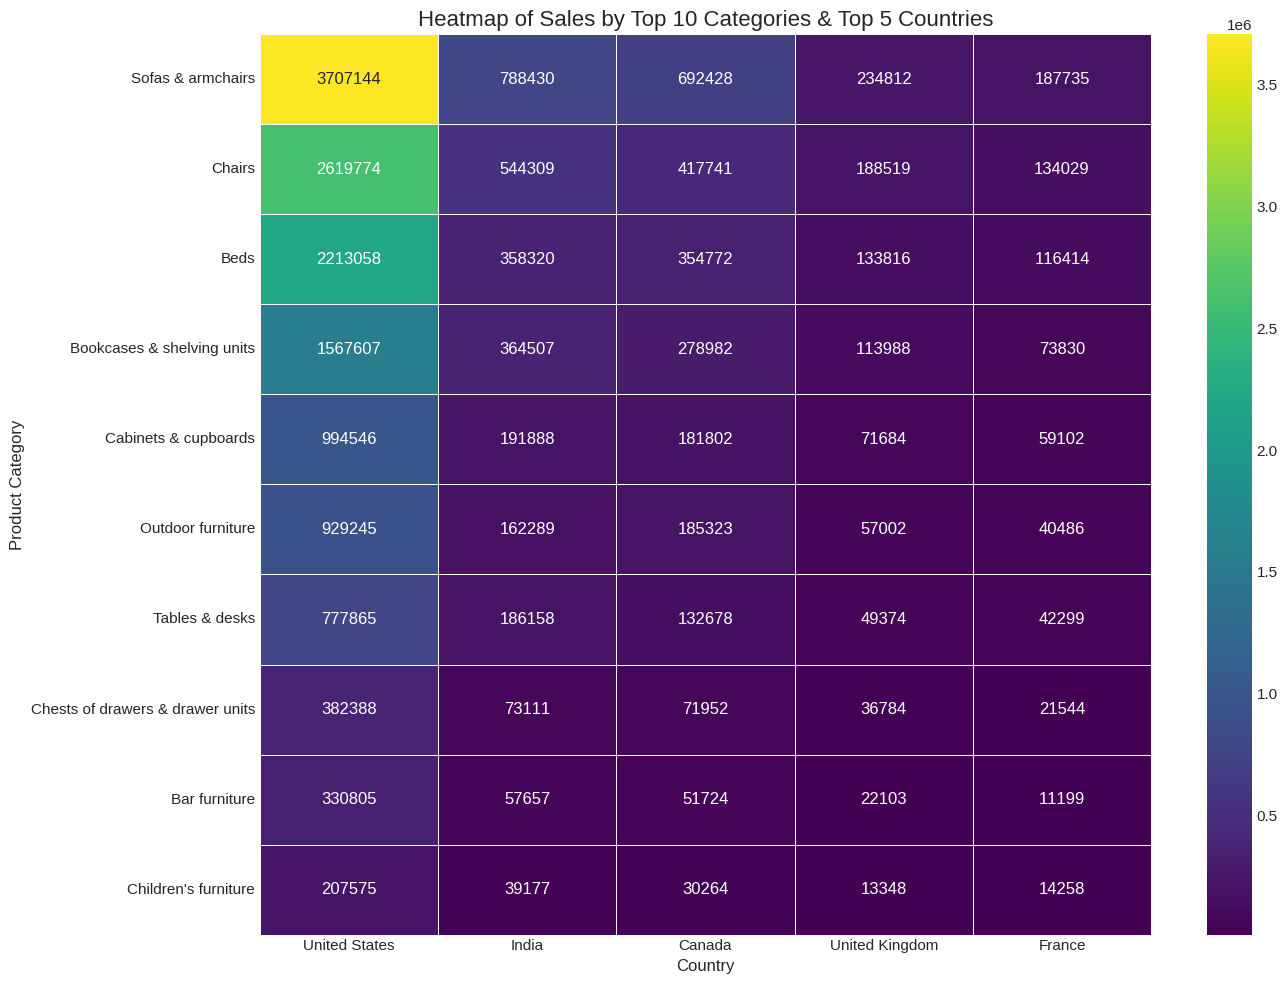

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
top_10_cat_names = top_10_categories_global.index.tolist()
top_5_country_names = top_5_countries_sales['country'].tolist()

# Filter the sales DataFrame to include only data from the top categories and countries.
df_filtered_pivot = df_sales[
    df_sales['category'].isin(top_10_cat_names) &
    df_sales['country'].isin(top_5_country_names)
].copy()


# --- Pivot Table Creation ---
# Create the pivot table summing the price for each category/country pair.
sales_pivot_table = pd.pivot_table(
    df_filtered_pivot,
    index='category',
    columns='country',
    values='price',
    aggfunc='sum',
    fill_value=0
)

# Sort the pivot table rows and columns based on the previously calculated overall rankings for a cleaner look.
sales_pivot_table = sales_pivot_table.reindex(top_10_cat_names)
sales_pivot_table = sales_pivot_table[top_5_country_names]

print("--- Pivot Table: Sales by Top Categories and Countries ---")
print(sales_pivot_table)


# --- Visualization (Heatmap) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

# Create the heatmap
sns.heatmap(
    sales_pivot_table,
    annot=True,
    fmt='.0f',
    cmap='viridis',
    linewidths=.5,
    ax=ax
)

# --- Customize the plot ---
ax.set_title('Heatmap of Sales by Top 10 Categories & Top 5 Countries', fontsize=16)
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)


# --- Final Adjustments ---
plt.tight_layout()
plt.savefig('sales_category_country_pivot_heatmap.png')
plt.show()

---
## Statistical Relationship Analysis

This section applies statistical methods to uncover deeper relationships within the data. Instead of just observing trends, we will now quantify the strength and significance of the connections between key business metrics.
---

### 19. Correlation Between Daily Sessions and Sales
---

The first analysis investigates the relationship between the total number of user sessions per day and the total sales revenue on that day. A strong positive correlation would suggest that efforts to increase site traffic are effectively translating into increased sales.

The methodology is as follows:
1.  Aggregate total sales and unique sessions by date.
2.  Visualize the relationship with a scatter plot, including a regression line to show the trend.
3.  Calculate the **Pearson correlation coefficient (r)** to measure the strength and direction of the linear relationship.
4.  Determine the **p-value** to assess the statistical significance of the correlation.

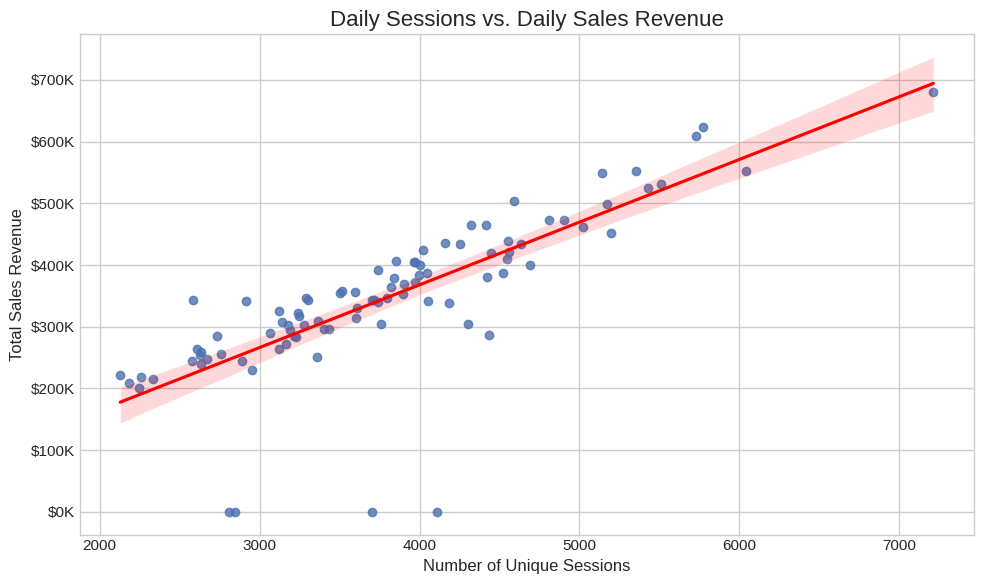

Pearson Correlation Coefficient: 0.7911
P-value: 0.0000
The correlation is statistically significant (p < 0.05).


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

daily_sales = df_sales.groupby('date')['price'].sum()
daily_sessions = df.groupby('date')['ga_session_id'].nunique()

metrics_df = pd.DataFrame({
    'sales': daily_sales,
    'sessions': daily_sessions
}).fillna(0)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(
    data=metrics_df,
    x='sessions',
    y='sales',
    ax=ax,
    line_kws={"color": "red"}
)

ax.set_title('Daily Sessions vs. Daily Sales Revenue', fontsize=16)
ax.set_xlabel('Number of Unique Sessions', fontsize=12)
ax.set_ylabel('Total Sales Revenue', fontsize=12)
ax.yaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

plt.tight_layout()
plt.savefig('sessions_vs_sales_correlation.png')
plt.show()

correlation_coefficient, p_value = pearsonr(metrics_df['sessions'], metrics_df['sales'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The correlation is statistically significant (p < 0.05).")
else:
    print("The correlation is not statistically significant (p >= 0.05).")

### Interpretation of Results

* **Correlation Coefficient (r):** This value ranges from -1 to 1. A value close to 1 indicates a strong positive linear relationship (as sessions increase, sales tend to increase). A value close to -1 indicates a strong negative relationship. A value near 0 suggests a weak or non-existent linear relationship.
* **P-value:** This value helps determine if the observed correlation is real or if it could have occurred by random chance. A p-value less than 0.05 is the standard threshold to conclude that the correlation is statistically significant. This means there is less than a 5% probability that you would observe this relationship in your sample if no such relationship existed in the population.

---
### 20. Inter-Continental Sales Correlation

This analysis explores whether the daily sales patterns in the top-performing continents move in tandem. We will examine the top 3 continents (Americas, Asia, and Europe) to see if their sales trends are correlated.

A strong positive correlation might suggest that global factors (like worldwide marketing campaigns or holidays) have a similar effect across these key markets. A weak correlation could imply that the markets are driven by different, local factors and should be managed independently. The analysis involves calculating a pairwise correlation matrix, visualizing it as a heatmap, and testing the statistical significance of each relationship.

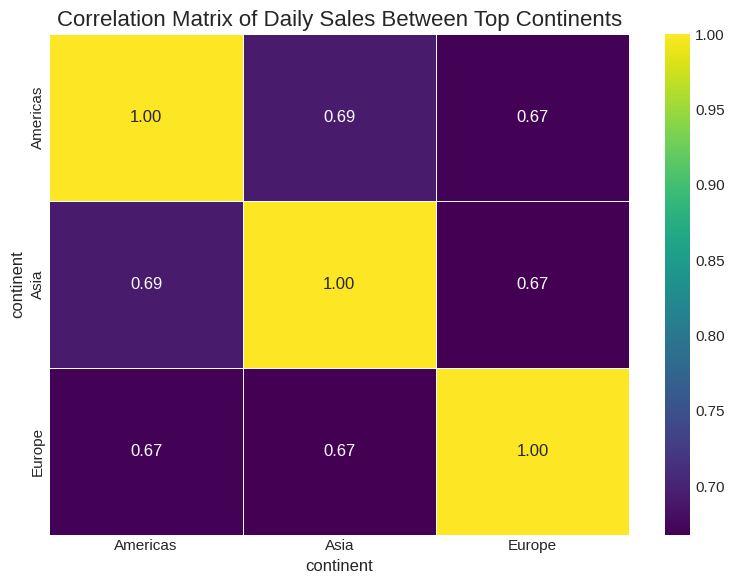

--- Statistical Significance (p-values) ---

Correlation between Americas and Asia:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Americas and Europe:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Asia and Europe:
  P-value: 0.0000
  The correlation is statistically significant.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

daily_sales_by_continent = df_sales.groupby(['date', 'continent'])['price'].sum().unstack()
continents_to_analyze = ['Americas', 'Asia', 'Europe']
daily_sales_by_continent = daily_sales_by_continent[continents_to_analyze].asfreq('D', fill_value=0)

correlation_matrix = daily_sales_by_continent.corr()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5,
    ax=ax
)

ax.set_title('Correlation Matrix of Daily Sales Between Top Continents', fontsize=16)

plt.tight_layout()
plt.savefig('intercontinental_sales_correlation.png')
plt.show()

print("--- Statistical Significance (p-values) ---")

continent_pairs = combinations(continents_to_analyze, 2)

for pair in continent_pairs:
    continent1, continent2 = pair

    corr_coef, p_value = pearsonr(
        daily_sales_by_continent[continent1],
        daily_sales_by_continent[continent2]
    )

    print(f"\nCorrelation between {continent1} and {continent2}:")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("  The correlation is statistically significant.")
    else:
        print("  The correlation is not statistically significant.")

---
### 21. Inter-Channel Sales Correlation

This analysis investigates the relationships between the daily sales performance of different traffic channels. By understanding how these channels correlate, we can gain insights into our marketing mix and customer behavior.

For instance, a strong positive correlation between two channels could indicate that they are influenced by the same marketing campaigns or seasonal trends. A lack of correlation might suggest that channels operate independently, reaching different audience segments. We will quantify these relationships using a correlation matrix and test their statistical significance.

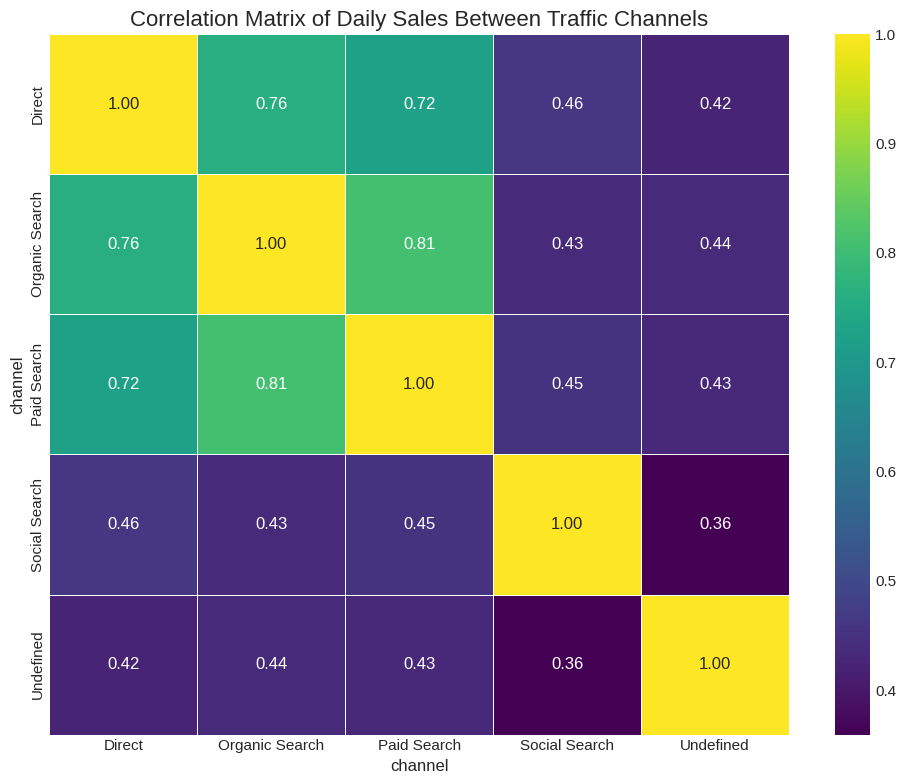

--- Statistical Significance (p-values) ---

Correlation between Direct and Organic Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Direct and Paid Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Direct and Social Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Direct and Undefined:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Organic Search and Paid Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Organic Search and Social Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Organic Search and Undefined:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Paid Search and Social Search:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Paid Search a

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

daily_sales_by_channel = df_sales.groupby(['date', 'channel'])['price'].sum().unstack().fillna(0)

correlation_matrix_channel = daily_sales_by_channel.corr()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_matrix_channel,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5,
    ax=ax
)

ax.set_title('Correlation Matrix of Daily Sales Between Traffic Channels', fontsize=16)

plt.tight_layout()
plt.savefig('interchannel_sales_correlation.png')
plt.show()

print("--- Statistical Significance (p-values) ---")

channel_pairs = combinations(daily_sales_by_channel.columns, 2)

for pair in channel_pairs:
    channel1, channel2 = pair

    corr_coef, p_value = pearsonr(
        daily_sales_by_channel[channel1],
        daily_sales_by_channel[channel2]
    )

    print(f"\nCorrelation between {channel1} and {channel2}:")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("  The correlation is statistically significant.")
    else:
        print("  The correlation is not statistically significant.")

---
### 22. Inter-Category Sales Correlation (Top 5)

This final correlation analysis examines if sales of the top 5 product categories move together. Understanding these relationships can reveal customer purchasing patterns, such as whether certain top-selling items are bought in conjunction or during the same shopping seasons.

A positive correlation could suggest cross-sell opportunities or that the products appeal to a similar seasonal demand. A lack of correlation might imply that the products serve different customer needs or purchase occasions. The methodology remains consistent: we will build a correlation matrix, visualize it with a heatmap, and test for statistical significance.

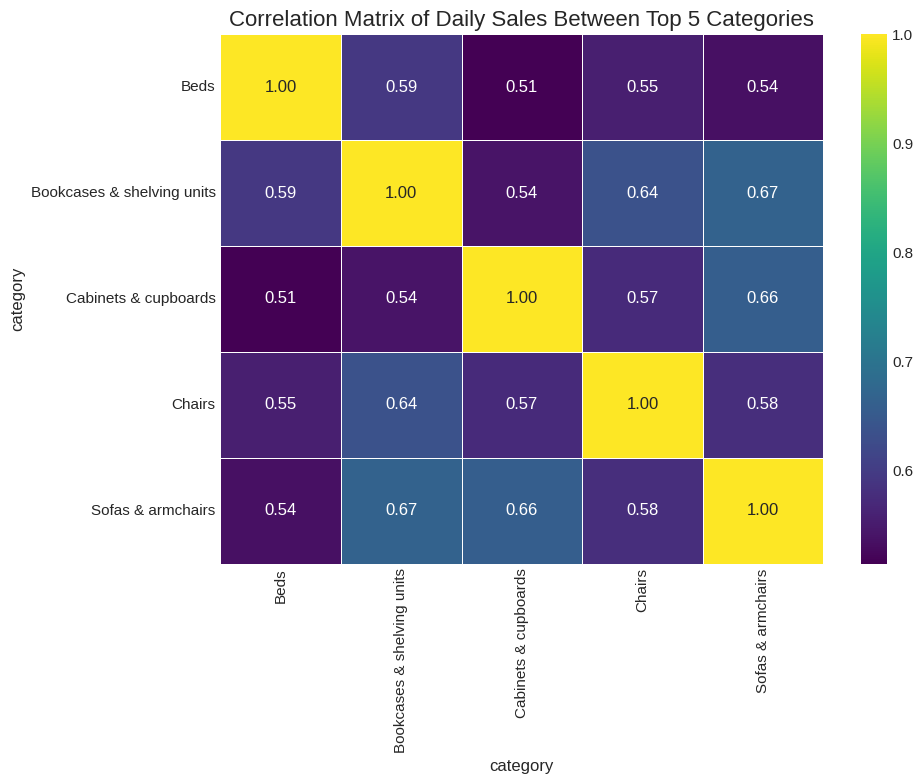

--- Statistical Significance (p-values) ---

Correlation between Beds and Bookcases & shelving units:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Beds and Cabinets & cupboards:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Beds and Chairs:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Beds and Sofas & armchairs:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Bookcases & shelving units and Cabinets & cupboards:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Bookcases & shelving units and Chairs:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Bookcases & shelving units and Sofas & armchairs:
  P-value: 0.0000
  The correlation is statistically significant.

Correlation between Cabinets & cupboards and Chairs:
  P-value: 0.0000
  The correlation is

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

top_5_cat_names = top_10_categories_global.head(5).index.tolist()

df_top_categories = df_sales[df_sales['category'].isin(top_5_cat_names)]

daily_sales_by_category = df_top_categories.groupby(['date', 'category'])['price'].sum().unstack().fillna(0)

correlation_matrix_category = daily_sales_by_category.corr()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_matrix_category,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5,
    ax=ax
)

ax.set_title('Correlation Matrix of Daily Sales Between Top 5 Categories', fontsize=16)

plt.tight_layout()
plt.savefig('intercategory_sales_correlation.png')
plt.show()

print("--- Statistical Significance (p-values) ---")

category_pairs = combinations(daily_sales_by_category.columns, 2)

for pair in category_pairs:
    category1, category2 = pair

    corr_coef, p_value = pearsonr(
        daily_sales_by_category[category1],
        daily_sales_by_category[category2]
    )

    print(f"\nCorrelation between {category1} and {category2}:")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("  The correlation is statistically significant.")
    else:
        print("  The correlation is not statistically significant.")

---
## Statistical Group Comparison

This final analytical section uses hypothesis testing to determine if observed differences between various user or traffic groups are statistically significant or likely due to random chance.
---



### 23. Daily Sales: Registered vs. Unregistered Users

---
The first test aims to answer: "Do registered users and unregistered guests generate a statistically different amount of sales revenue per day?" Answering this helps quantify the value of the user registration system.

The methodology is as follows:
1.  **Create Samples:** Separate the daily sales data into two distinct groups: sales from registered users and sales from guests.
2.  **Test for Normality:** Analyze the distribution of each sample. We'll use histograms for a visual check and the **Shapiro-Wilk test** for a formal statistical confirmation. This step is crucial for selecting the correct comparison test.
3.  **Select and Perform Test:**
    * If the data is normally distributed, we will use the **independent t-test**.
    * If the data is not normally distributed, we will use the non-parametric equivalent, the **Mann-Whitney U test**.
4.  **Conclusion:** Interpret the p-value from the test to conclude if a significant difference exists.

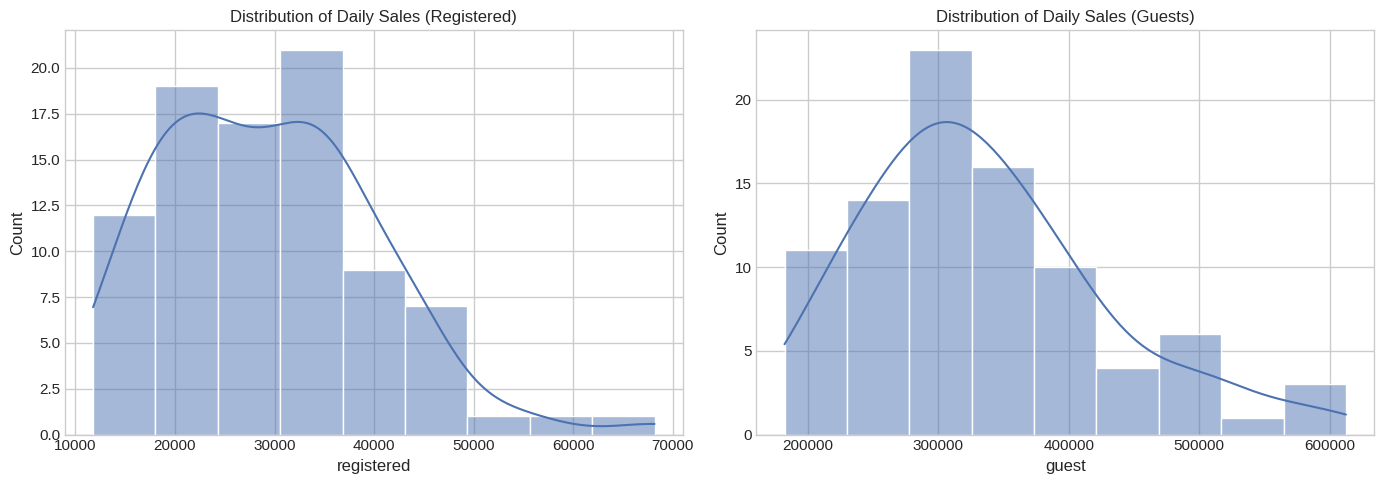

Shapiro-Wilk Test for Registered Users: Statistic=0.9592, p-value=0.0073
Shapiro-Wilk Test for Guests: Statistic=0.9522, p-value=0.0026

At least one distribution is not normal. Performing Mann-Whitney U test.
Mann-Whitney U Test Results: Statistic=0.0000, p-value=0.0000

Conclusion: There is a statistically significant difference in daily sales between registered and guest users.


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

registered_sales = df_sales[df_sales['account_id'].notna()].groupby('date')['price'].sum()
guest_sales = df_sales[df_sales['account_id'].isna()].groupby('date')['price'].sum()

sales_comparison_df = pd.DataFrame({'registered': registered_sales, 'guest': guest_sales}).asfreq('D', fill_value=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(sales_comparison_df['registered'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Daily Sales (Registered)')
sns.histplot(sales_comparison_df['guest'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Daily Sales (Guests)')
plt.tight_layout()
plt.show()

shapiro_registered = stats.shapiro(sales_comparison_df['registered'])
shapiro_guest = stats.shapiro(sales_comparison_df['guest'])

print(f"Shapiro-Wilk Test for Registered Users: Statistic={shapiro_registered.statistic:.4f}, p-value={shapiro_registered.pvalue:.4f}")
print(f"Shapiro-Wilk Test for Guests: Statistic={shapiro_guest.statistic:.4f}, p-value={shapiro_guest.pvalue:.4f}")

is_registered_normal = shapiro_registered.pvalue > 0.05
is_guest_normal = shapiro_guest.pvalue > 0.05

if is_registered_normal and is_guest_normal:
    print("\nBoth distributions are normal. Performing Independent t-test.")
    test_stat, p_value = stats.ttest_ind(sales_comparison_df['registered'], sales_comparison_df['guest'])
    print(f"T-test Results: Statistic={test_stat:.4f}, p-value={p_value:.4f}")
else:
    print("\nAt least one distribution is not normal. Performing Mann-Whitney U test.")
    test_stat, p_value = stats.mannwhitneyu(sales_comparison_df['registered'], sales_comparison_df['guest'])
    print(f"Mann-Whitney U Test Results: Statistic={test_stat:.4f}, p-value={p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: There is a statistically significant difference in daily sales between registered and guest users.")
else:
    print("\nConclusion: There is no statistically significant difference in daily sales between registered and guest users.")

### Interpretation of Results

* **Normality Test (Shapiro-Wilk):** The p-value from this test tells us if the data deviates from a normal distribution. If p < 0.05, we reject the hypothesis of normality and must use a non-parametric test.
* **Comparison Test (t-test or Mann-Whitney U):** The final p-value from this test answers our main question. If this p-value is less than 0.05, we can confidently conclude that the difference in daily sales between the two groups is real and not just a random fluctuation in our data.

---
### 24. Session Count Comparison Across Traffic Channels

This test aims to determine if there is a statistically significant difference in the average number of daily sessions driven by each traffic channel. In essence, are the observed differences in traffic volumes between channels genuine, or could they be a result of random daily fluctuations?

The methodology is as follows:
1.  **Create Samples:** Create a data sample of daily session counts for each traffic channel.
2.  **Test for Normality:** Check the distribution of each sample using the Shapiro-Wilk test to determine if we can assume normality.
3.  **Select and Perform Test:**
    * If all samples are normally distributed, we use **ANOVA (Analysis of Variance)**.
    * If any sample is not normally distributed, we use the **Kruskal-Wallis H test**.
4.  **Conclusion:** Interpret the test's p-value to determine if a significant difference exists among the groups.

In [47]:
import pandas as pd
from scipy import stats

daily_sessions_by_channel = df.groupby(['date', 'channel'])['ga_session_id'].nunique().unstack().fillna(0)

samples = [daily_sessions_by_channel[col] for col in daily_sessions_by_channel.columns]
all_normal = True

print("--- Normality Test for Each Channel ---")
for i, col in enumerate(daily_sessions_by_channel.columns):
    shapiro_test = stats.shapiro(samples[i])
    print(f"Channel '{col}': p-value = {shapiro_test.pvalue:.4f}")
    if shapiro_test.pvalue < 0.05:
        all_normal = False

if all_normal:
    print("\nAll distributions appear normal. Performing one-way ANOVA test.")
    f_stat, p_value = stats.f_oneway(*samples)
    print(f"ANOVA Test Results: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")
else:
    print("\nAt least one distribution is not normal. Performing Kruskal-Wallis H test.")
    h_stat, p_value = stats.kruskal(*samples)
    print(f"Kruskal-Wallis Test Results: H-statistic={h_stat:.4f}, p-value={p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: There is a statistically significant difference in the number of daily sessions among the traffic channels.")
else:
    print("\nConclusion: There is no statistically significant difference in the number of daily sessions among the traffic channels.")

--- Normality Test for Each Channel ---
Channel 'Direct': p-value = 0.0343
Channel 'Organic Search': p-value = 0.0123
Channel 'Paid Search': p-value = 0.0108
Channel 'Social Search': p-value = 0.1413
Channel 'Undefined': p-value = 0.0546

At least one distribution is not normal. Performing Kruskal-Wallis H test.
Kruskal-Wallis Test Results: H-statistic=368.9806, p-value=0.0000

Conclusion: There is a statistically significant difference in the number of daily sessions among the traffic channels.


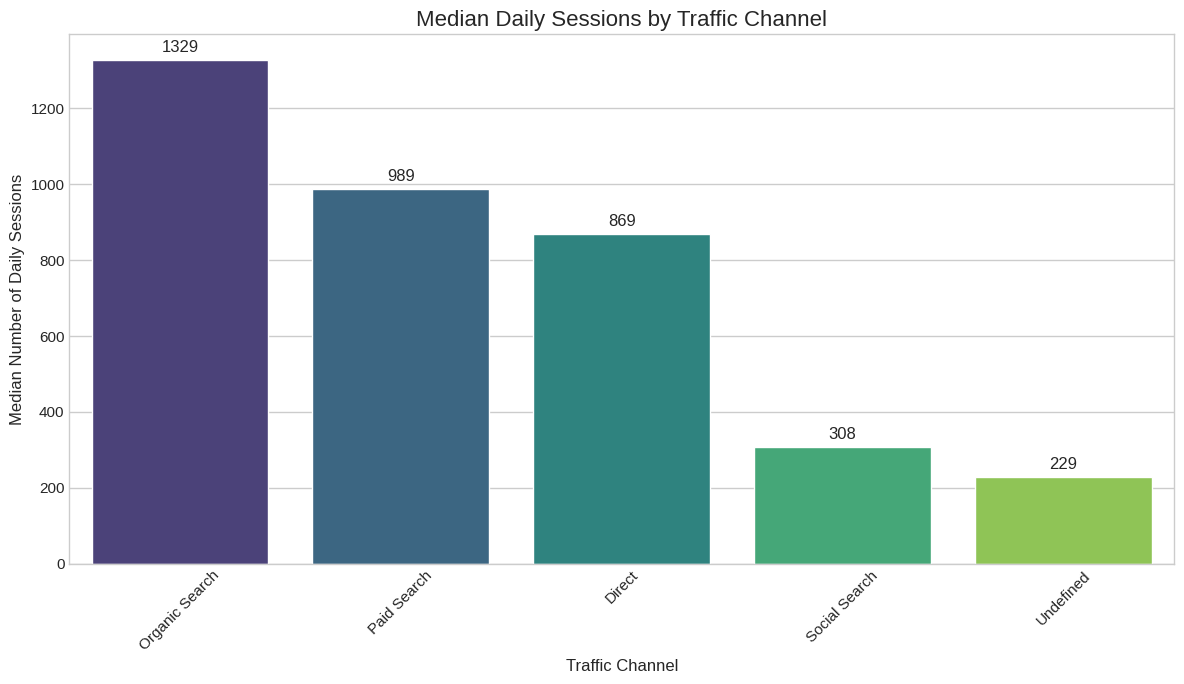

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

daily_sessions_by_channel = df.groupby(['date', 'channel'])['ga_session_id'].nunique().unstack().fillna(0)

median_sessions = daily_sessions_by_channel.median().sort_values(ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x=median_sessions.index,
    y=median_sessions.values,
    ax=ax,
    hue=median_sessions.index,
    palette='viridis',
    legend=False
)

ax.set_title('Median Daily Sessions by Traffic Channel', fontsize=16)
ax.set_xlabel('Traffic Channel', fontsize=12)
ax.set_ylabel('Median Number of Daily Sessions', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()

plt.show()

---
### 25. Comparing Proportions of Organic Traffic: Europe vs. Americas

This final statistical test investigates whether the proportion of website sessions originating from 'Organic Search' is significantly different between Europe and the Americas. This is a classic "test of two proportions."

Answering this question helps to gauge the relative effectiveness of Search Engine Optimization (SEO) efforts in these two critical markets. A significant difference might justify a strategic shift in SEO resources or a deeper investigation into regional search behavior.

The methodology is:
1.  Calculate the total number of sessions and the number of organic search sessions for both continents.
2.  Perform a **two-proportion z-test** to compare the ratios.
3.  Interpret the p-value to conclude if the difference in proportions is statistically significant.

In [50]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

df_eu = df[df['continent'] == 'Europe']
df_am = df[df['continent'] == 'Americas']

n_total_eu = len(df_eu)
n_organic_eu = len(df_eu[df_eu['channel'] == 'Organic Search'])

n_total_am = len(df_am)
n_organic_am = len(df_am[df_am['channel'] == 'Organic Search'])

print("--- Input Data for the Test ---")
print(f"Europe: {n_organic_eu} organic sessions out of {n_total_eu} total.")
print(f"Americas: {n_organic_am} organic sessions out of {n_total_am} total.")

prop_eu = n_organic_eu / n_total_eu
prop_am = n_organic_am / n_total_am

print(f"\nProportion of Organic Traffic in Europe: {prop_eu:.2%}")
print(f"Proportion of Organic Traffic in Americas: {prop_am:.2%}")

count = [n_organic_eu, n_organic_am]
nobs = [n_total_eu, n_total_am]

z_stat, p_value = proportions_ztest(count, nobs)

print("\n--- Two-Proportion Z-Test Results ---")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: The difference in the proportion of organic traffic between Europe and the Americas is statistically significant.")
else:
    print("\nConclusion: There is no statistically significant difference in the proportion of organic traffic between Europe and the Americas.")

--- Input Data for the Test ---
Europe: 23195 organic sessions out of 65135 total.
Americas: 68671 organic sessions out of 193179 total.

Proportion of Organic Traffic in Europe: 35.61%
Proportion of Organic Traffic in Americas: 35.55%

--- Two-Proportion Z-Test Results ---
Z-statistic: 0.2895
P-value: 0.7722

Conclusion: There is no statistically significant difference in the proportion of organic traffic between Europe and the Americas.


### Interpretation of Results

The two-proportion z-test is used to determine if the proportions of a certain characteristic (in this case, 'Organic Search' traffic) are the same in two different populations.

The p-value is the key result. If the p-value is less than the standard threshold of 0.05, it means that the observed difference between the two proportions is large enough to be considered statistically significant. You can conclude that the effectiveness or presence of organic search as a traffic driver is genuinely different in Europe compared to the Americas.

---
### 26. Post-Hoc Analysis: Pairwise Comparison of Traffic Channels

Since the Kruskal-Wallis test was significant, it confirmed that at least one channel's daily session distribution is different from the others. To identify which specific pairs of channels are different, we will perform **Dunn's post-hoc test**. This test compares each channel against every other channel in a pairwise manner while adjusting the p-values to control for multiple comparisons (using the Bonferroni correction), which prevents false positives.

In [51]:
try:
    import scikit_posthocs as sp
except ImportError:
    print("Installing required library: scikit-posthocs...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-posthocs'], stdout=subprocess.DEVNULL)
    import scikit_posthocs as sp
import pandas as pd

daily_sessions_by_channel = df.groupby(['date', 'channel'])['ga_session_id'].nunique().unstack().fillna(0)
samples = [daily_sessions_by_channel[col] for col in daily_sessions_by_channel.columns]
channel_names = daily_sessions_by_channel.columns

dunn_results = sp.posthoc_dunn(samples, p_adjust='bonferroni')
dunn_results.columns = channel_names
dunn_results.index = channel_names

print("--- Pairwise Comparison (Dunn's Test P-values) ---")
print(dunn_results)

Installing required library: scikit-posthocs...
--- Pairwise Comparison (Dunn's Test P-values) ---
channel               Direct  Organic Search   Paid Search  Social Search  \
channel                                                                     
Direct          1.000000e+00    6.323122e-08  4.326742e-01   4.304460e-15   
Organic Search  6.323122e-08    1.000000e+00  1.525628e-03   3.740352e-43   
Paid Search     4.326742e-01    1.525628e-03  1.000000e+00   3.286805e-23   
Social Search   4.304460e-15    3.740352e-43  3.286805e-23   1.000000e+00   
Undefined       4.847586e-23    4.546360e-56  6.982112e-33   4.735275e-01   

channel            Undefined  
channel                       
Direct          4.847586e-23  
Organic Search  4.546360e-56  
Paid Search     6.982112e-33  
Social Search   4.735275e-01  
Undefined       1.000000e+00  


---
### 27. Conversion Rate Analysis by Traffic Channel

This analysis investigates whether the traffic channel is independent of the purchase outcome. We want to determine if the conversion rate is statistically the same across all channels. A significant result would imply that some channels are better at bringing in "quality" traffic that is more likely to convert. We will use the **Chi-Square Test of Independence** for this analysis.

In [52]:
import pandas as pd
from scipy.stats import chi2_contingency

df_conv = df.dropna(subset=['channel', 'ga_session_id']).copy()
df_conv['has_purchase'] = ~df_conv['price'].isnull() & (df_conv['price'] > 0)

contingency_table = pd.crosstab(df_conv['channel'], df_conv['has_purchase'])

print("\n--- Contingency Table (Sessions without Purchase / with Purchase) ---")
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("\n--- Chi-Square Test of Independence Results ---")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: There is a statistically significant relationship between traffic channel and making a purchase. Conversion rates differ by channel.")
else:
    print("\nConclusion: There is no statistically significant relationship. The conversion rate can be considered the same across all channels.")


--- Contingency Table (Sessions without Purchase / with Purchase) ---
has_purchase     False  True 
channel                      
Direct           73582   7800
Organic Search  112504  11921
Paid Search      85299   9042
Social Search    25198   2716
Undefined        19424   2059

--- Chi-Square Test of Independence Results ---
Chi-Square Statistic: 0.6397
P-value: 0.9586

Conclusion: There is no statistically significant relationship. The conversion rate can be considered the same across all channels.


---
---
# **Executive Summary**


This analysis of e-commerce sales data from November 1, 2020, to January 31, 2021, reveals a robust and healthy business model with $32 million in sales driven by a strong product-market fit in North America. The findings indicate that growth is primarily fueled by high-value furniture categories, with a well-performing marketing mix where all channels deliver high-quality, convertible traffic. Statistical analysis has confirmed that while traffic volume differs significantly across channels, the probability of conversion does not, pointing to a uniformly engaged customer base. The most critical strategic insights identified are the significant financial value of registered users and a key behavioral gap between mobile Browse and desktop purchasing. The following recommendations provide a data-driven roadmap for optimizing the customer journey and maximizing marketing ROI.

## **Key Findings**
---

* Dominance of the North American Market: The business is heavily centered on the Americas, which accounts for over 55% of total sales ($17.6M).

* High-Value Product Portfolio: Sales are concentrated in high-ticket items. The top three categories—Sofas & armchairs, Chairs, and Beds—collectively generated over $19.4 million, representing more than 60% of total sales. This indicates a strong market position in the core furniture sector.

* All Traffic is "Quality" Traffic: A Chi-Square test confirmed with high confidence (p-value = 0.9586) that there is no statistically significant difference in conversion rates between traffic channels. Whether a user arrives from Organic Search, Paid Search, or Direct, their likelihood to purchase is the same. The primary difference between channels is the volume of traffic they generate, not the quality.

* The Mobile-to-Desktop Purchase Gap: While mobile devices are a significant part of the customer journey (38.7% of sales), desktops are the overwhelmingly preferred platform for completing a purchase (59.0% of sales). This suggests users often browse and research on mobile but switch to a desktop to finalize their high-value orders.

* Registered Users Drive Significantly More Revenue: A Mann-Whitney U test showed a statistically significant difference (p < 0.0001) in daily sales volume between registered users and guests. This confirms that encouraging users to create an account is a high-value strategy that directly correlates with increased daily revenue.


## **Strategic Recommendations**
---

- **Priority 1**: Optimize the Mobile-to-Desktop Customer Journey.
- Action: The data points to friction or a lack of confidence in the mobile purchasing experience. Focus on creating a seamless cross-device journey. Ensure the shopping cart is perfectly synchronized for logged-in users across devices. A/B test the mobile checkout process to reduce steps and simplify payment options.
- Goal: Bridge the gap between mobile Browse and purchasing, capturing revenue that is currently deferred or lost when users switch devices.

* **Priority 2**: Scale Marketing by Focusing on Volume, Not Quality.
- Action: Since all channels convert equally well, the primary marketing goal should be to increase the volume of qualified traffic. Double down on what works: continue investing heavily in SEO for Organic Search (your top-performing channel). Use insights from the post-hoc analysis—which showed Paid Search and Direct traffic are statistically similar—to inform a synergistic strategy. Use paid ads not just for direct conversion, but to build brand awareness that fuels high-value direct traffic.
- Goal: Increase overall sales by scaling the top of the marketing funnel, knowing that the conversion potential is consistent regardless of the channel.

* **Priority 3**: Nurture the Registered User Base.
- Action: The statistical significance of sales from registered users proves their value. Implement campaigns specifically aimed at increasing user registration. For the existing 71.7% of verified users, leverage this healthy, engaged list for targeted email marketing focused on driving repeat purchases and increasing Customer Lifetime Value (CLV).
- Goal: Systematically increase the size and value of the most profitable user segment.

* **Priority 4**: Develop a Low-Risk International Growth Plan.
- Action: The business is over-reliant on the US market. The data shows that your SEO is equally effective in Europe and the Americas (p-value = 0.77). Use this as a foundation for low-cost market expansion. Begin by creating targeted content and SEO strategies for other promising, high-user-count countries like the United Kingdom, Canada, and India.
- Goal: Mitigate strategic risk by diversifying revenue streams and establishing a foothold in secondary markets.